# Proyecto 02: Profundización en la generación de modelos

## Trabajo presentado por: David Serna Gutiérrez

### Consigna

En este proyecto profundizarás lo desarrollado en el proyecto 01 (“Primer modelo de Machine Learning”). **El objetivo es aplicar las técnicas incorporadas (Transformación de Datos, Optimización de Hiperparámetros, Modelos Avanzados, etc.) para generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior.** Luego, interpreta ese modelo para responder la siguiente pregunta: **¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?**

El trabajo se organiza en tres partes:

#### Checklist de evaluación:

    Este proyecto no cuenta con mínimos entregables indicados en la consigna, pero ten en cuenta lo siguiente:

    * en la Parte A debes implementar al menos tres de las transformaciones de datos propuestas.
    * en la Parte B, al menos un modelo debe ser optimizado por Grid Search o Random Search; el otro puede ser optimizado por búsqueda manual (es decir, puedes dejar los mejores parámetros que encontraste probando ).
    * en la Parte C, debes responder al menos una pregunta. Obviamente, ¡cuanto más hagas, más aprenderás y mejor será tu proyecto!

### SECCIÓN A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Implementa las transformaciones que elegiste. Es importante que justifiques por qué las haces:

* Detección y eliminación de Outliers

* Encoding

* Imputación de valores faltantes

* Escalado de datos

* Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - con este nuevo dataset transformado . Evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Compara con el desempeño obtenido en el proyecto 01. Sea cual sea la respuesta, intenta explicar a qué se debe.

Checklist de evaluación:

* Debes justificar por qué creés que las transformaciones elegidas aplican en este dataset. Ten en cuenta que, en el manejo de valores atípicos o en la imputación de valores faltantes, los valores obtenidos deben tener sentido. Por ejemplo, valores mayores que cero para superficies, número de baños, etc.

* Debes re entrenar un modelo del Proyecto 01 y comparar su desempeño con el modelo obtenido en el Proyecto 01. Una aclaración: con reentrenar nos referimos a usar el mismo proceso de entrenamiento junto con sus hiperparámetros. Pero puede ocurrir - y, de hecho, se espera - que el dataset contenga más atributos que los utilizados en el Proyecto 01.

___

# PARTE I
___

## SECCIÓN A

In [139]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import timeit

#Dataset original
properati_raw = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

Wall time: 2.41 s


Con base en la experencia del proyecto pasado, procederemos a realizar los siguientes procedimientos:

### A.1) Elección de las variables propicias para el estudio:

In [140]:
#Se dejará:
properati_trim = properati_raw[['l2', 'l3','rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','price','property_type']]

properati_trim.head()

#Más adelante se realizará encoding con las variables categóricas

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH


### A.2) Correción en la variable `surface_covered` mayor a `surface_total`:

In [141]:
%%time
#Esta pequeña funcion revisa cuántas veces sucede que surface_covered > surface_total o que surface_covered está vacía
###
def revisor_surface (data):
    error = 0
    valido = 0
    vacia = 0
    for i in data.index:
        if data.surface_covered[i] > data.surface_total[i]:
            error += 1
        elif data.surface_covered.isna()[i]:
            vacia += 1
        else:
            valido += 1
    print(f"El total de válidos es {valido}, invalidos {error} y vacias {vacia}")
###
#La corremos:
revisor_surface(properati_trim)

El total de válidos es 123614, invalidos 1432 y vacias 21614
Wall time: 16.7 s


In [142]:
warnings.filterwarnings('ignore')
#Creamos una copia del data set, le hacemos una máscara, para luego sacar los índices de esos valores
properati_copy = properati_trim.copy(deep=True)
mascara = properati_trim.surface_total[(properati_trim['surface_covered'] > properati_trim['surface_total']) | (properati_trim['surface_covered'].isna())]
indexes = mascara.index
#Corremos un for por los indices indicándole que en esos lugares se haga el remplazo
for i in indexes:
    properati_copy.surface_covered[i] = properati_copy.surface_total[i]

In [143]:
%%time
#Corremos la funcion para revisar:
revisor_surface(properati_copy)

El total de válidos es 126648, invalidos 0 y vacias 20012
Wall time: 16.3 s


Aunque hemos corregido el error de la superficie cubierta mayor a total. Estos atributos aún tienen valores faltantes:

### A.3) Trabajo con valores faltantes:

In [144]:
#Del anterior proyecto retomo esto para mirar los valores faltantes:
#Imprimir nombres de las columnas y verificar cuáles tienen valores faltantes y cuántos.
def valores_faltantes (data):
    names_cols = data.columns
    for i in names_cols: #* Ver nota a continuación sobre los for utilizados
        if pd.isnull(data[i]).any() == True:
            print(f"La columna {[i]} tiene {pd.isnull(data[i]).sum()} valores faltantes")
valores_faltantes(properati_copy)

La columna ['bathrooms'] tiene 5957 valores faltantes
La columna ['surface_total'] tiene 20527 valores faltantes
La columna ['surface_covered'] tiene 20012 valores faltantes


Ordenado por: l2
Ordenado por: l3
Ordenado por: rooms
Ordenado por: bedrooms
Ordenado por: bathrooms
Ordenado por: surface_total
Ordenado por: surface_covered
Ordenado por: price
Ordenado por: property_type


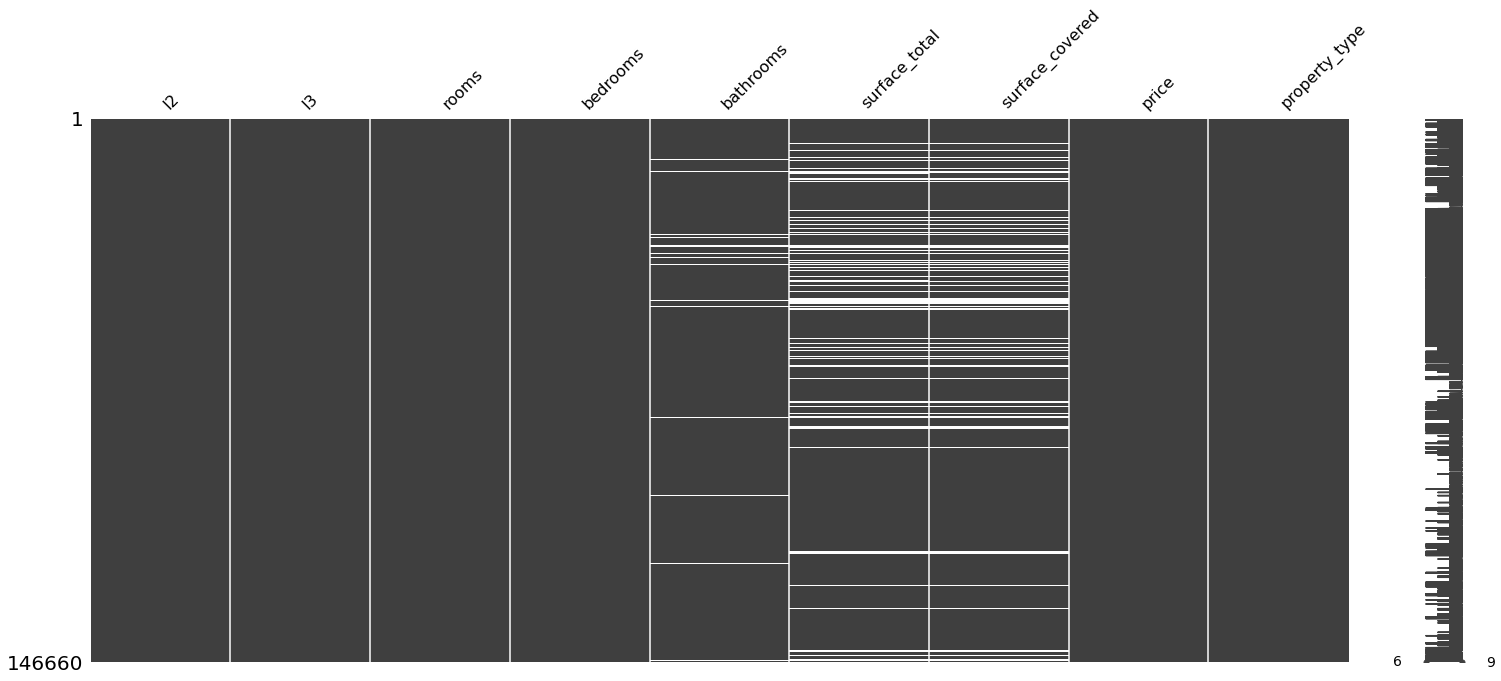

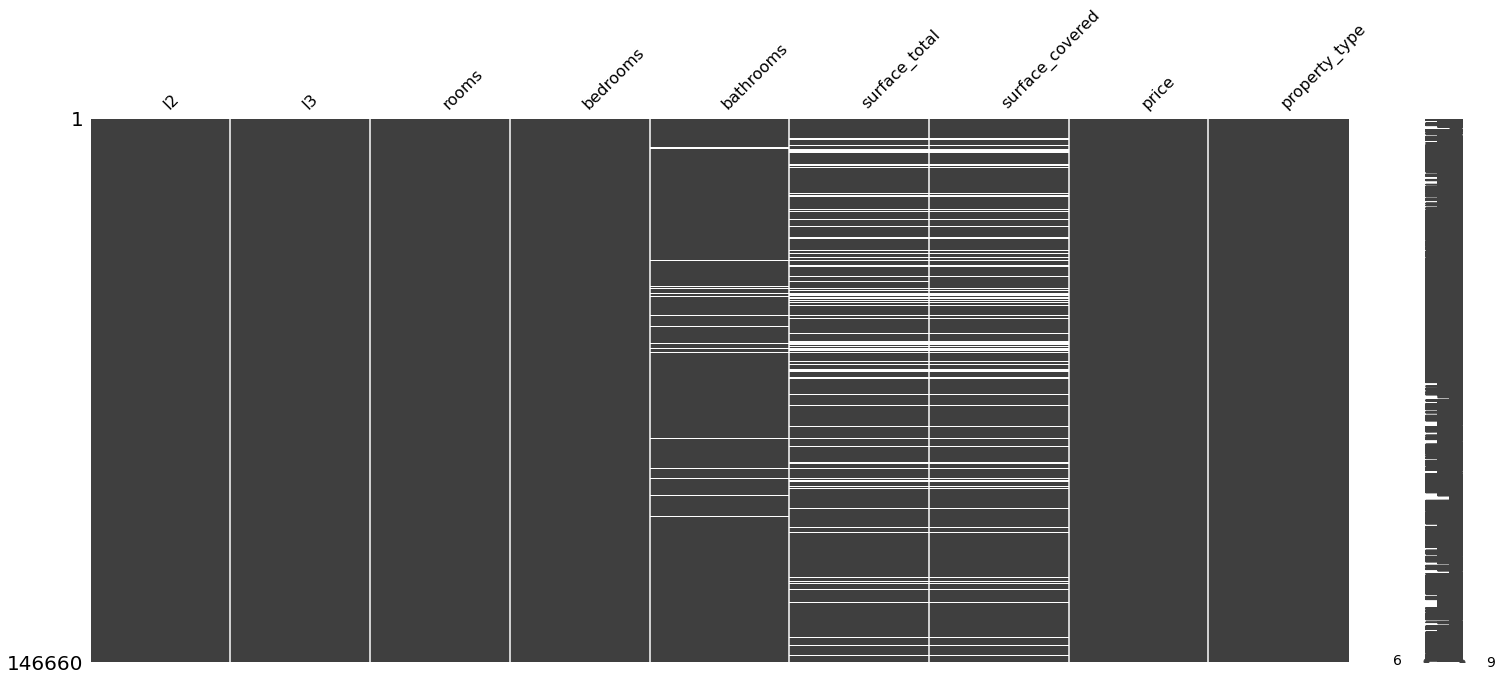

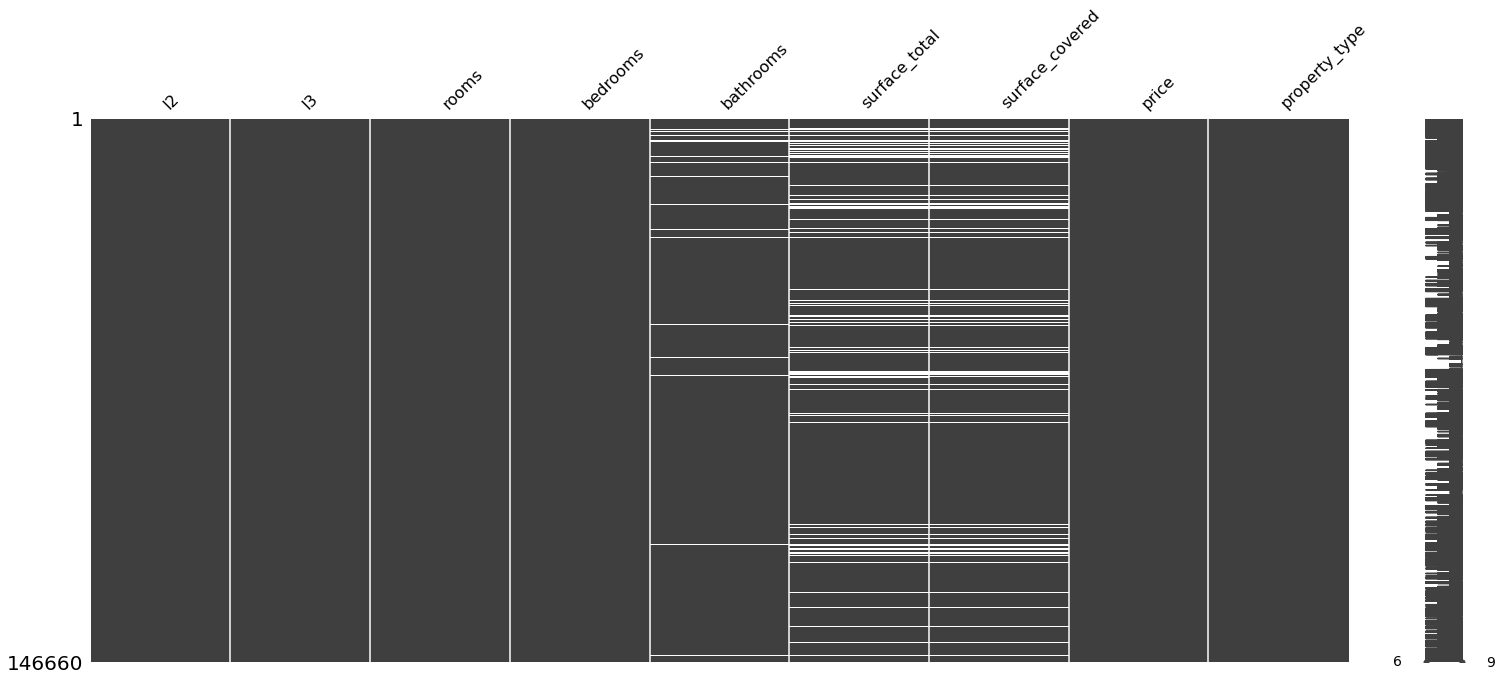

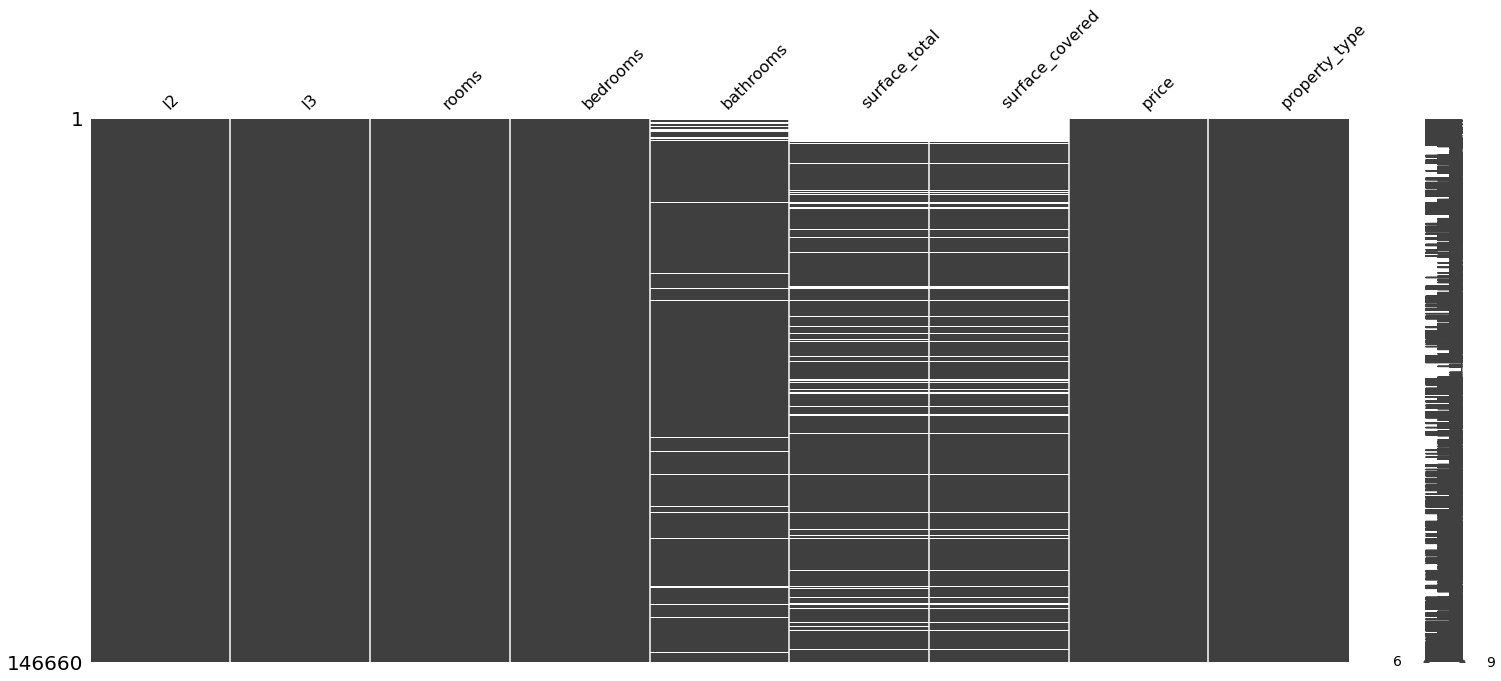

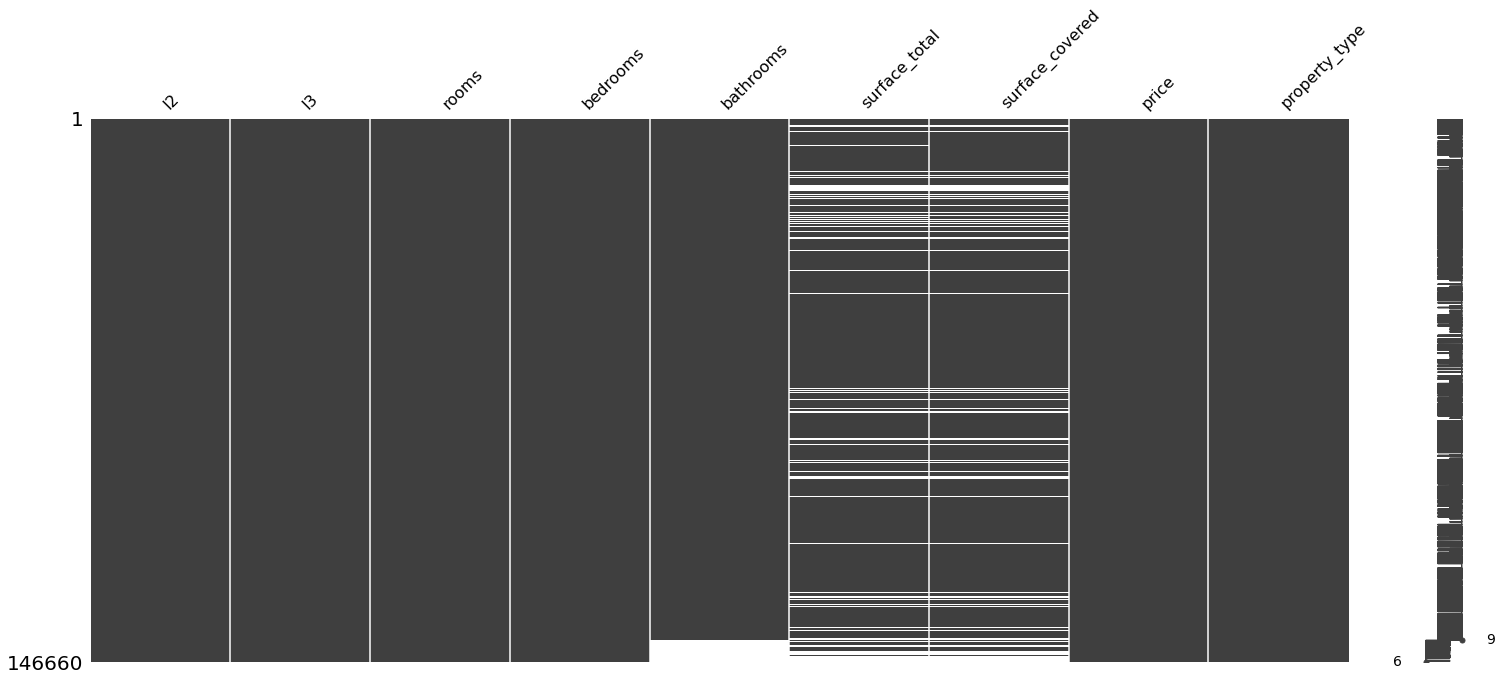

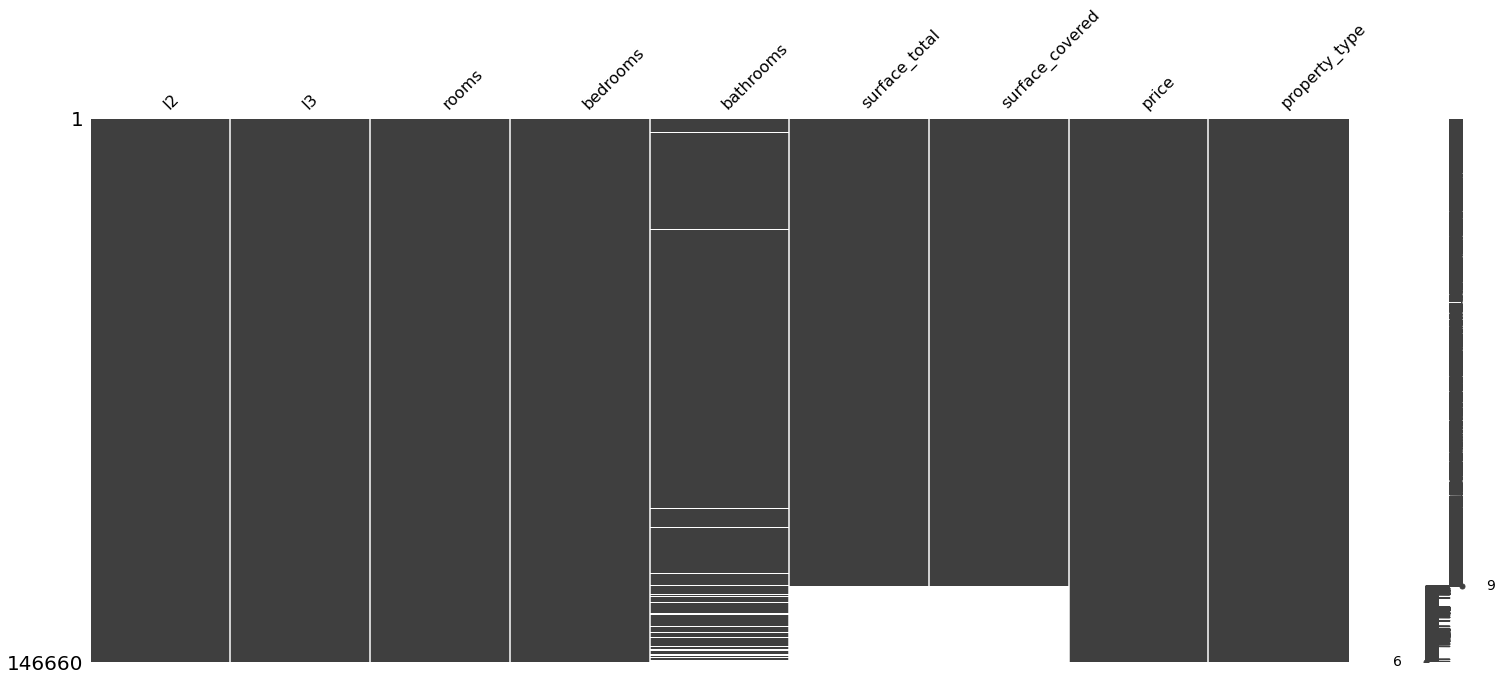

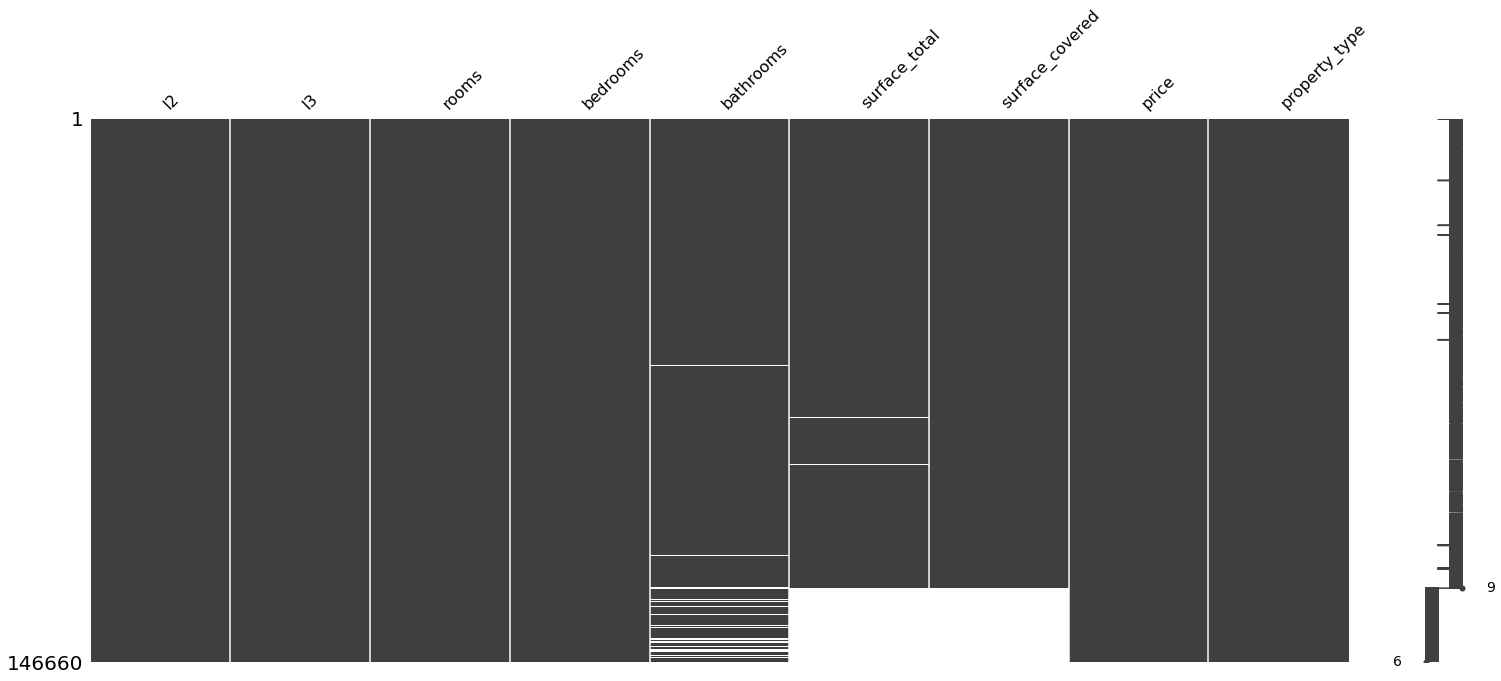

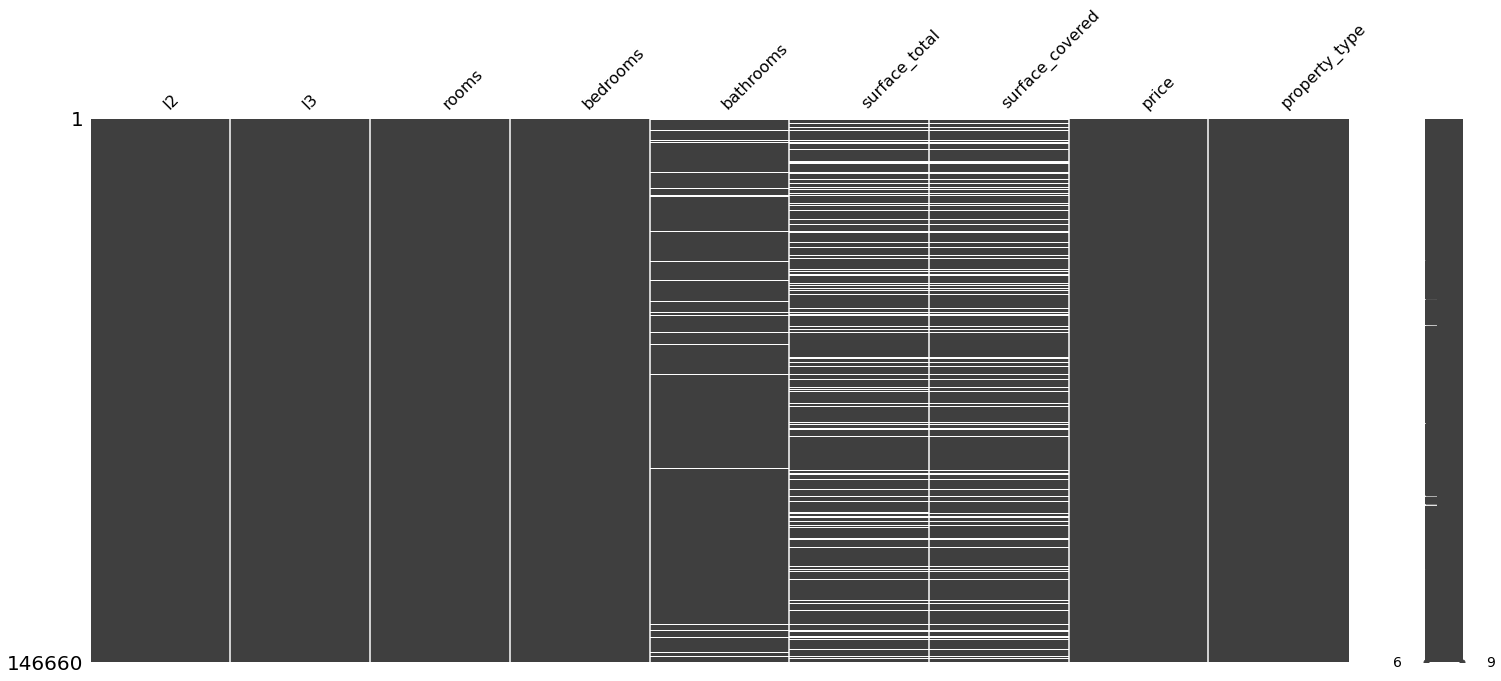

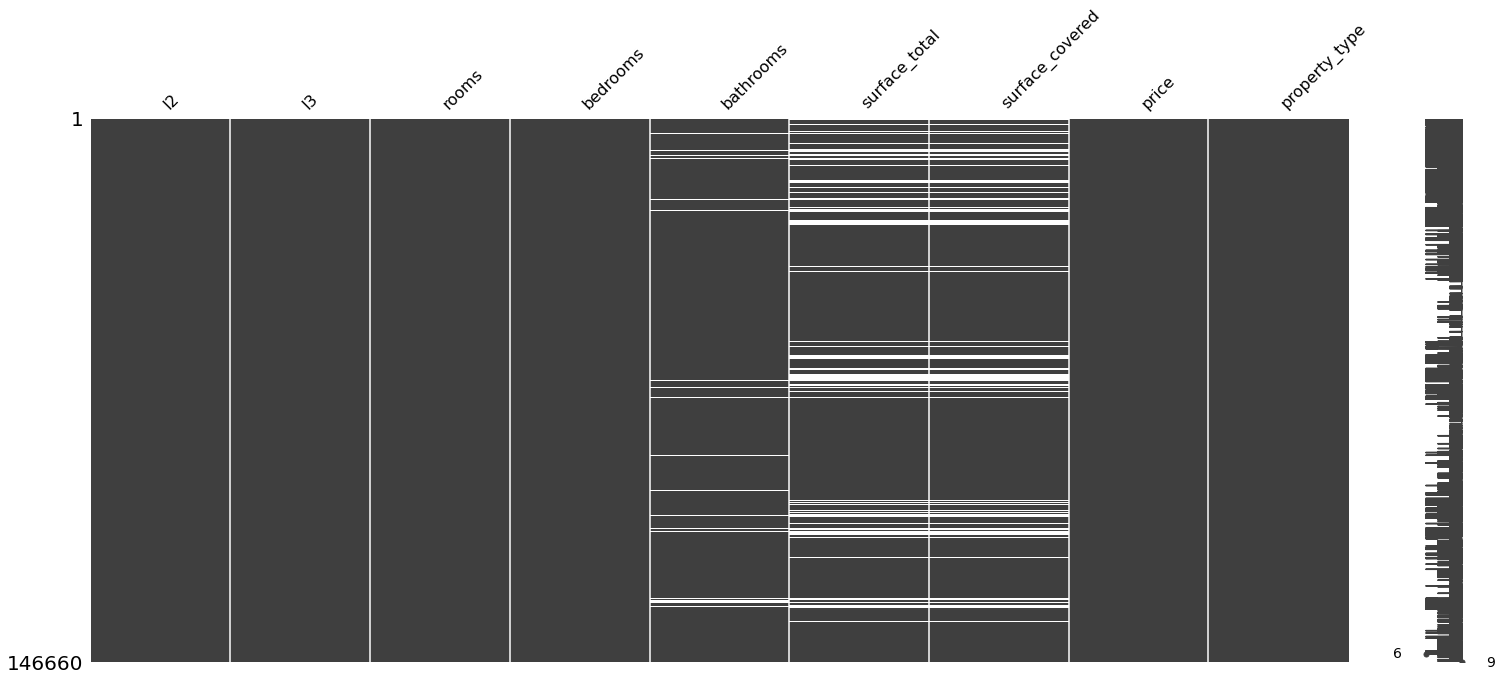

In [145]:
#Usaremos la librería missingno
import missingno as msno
#Voy a organizar por orden alfabético o númerico en cada variable para ver sí se observa algún patrón.
#Están ordenados de menor a mayor
for i in properati_copy.columns:
    sorted = properati_copy.sort_values(i)
    print(f"Ordenado por: {i}")
    msno.matrix(sorted)

Se observa que al ordenar por habitaciones, las de menor cantidad muestran tener el valor faltante de la superficie total y cubierta. Igualmente se observa que al ordenar por superficies, aquellas que no tienen superficie, algunas les falta la cantidad de baños

Al organizar los precios de menor a mayor, pareciera que los valores faltantes de superficie no están sujetos a ninguna otra variable. Por lo que podemos asumir que la variabilidad de los valores faltantes de la superficie total son aleatorios (TIPO MAR).

Ordenado por: bedrooms


<AxesSubplot:>

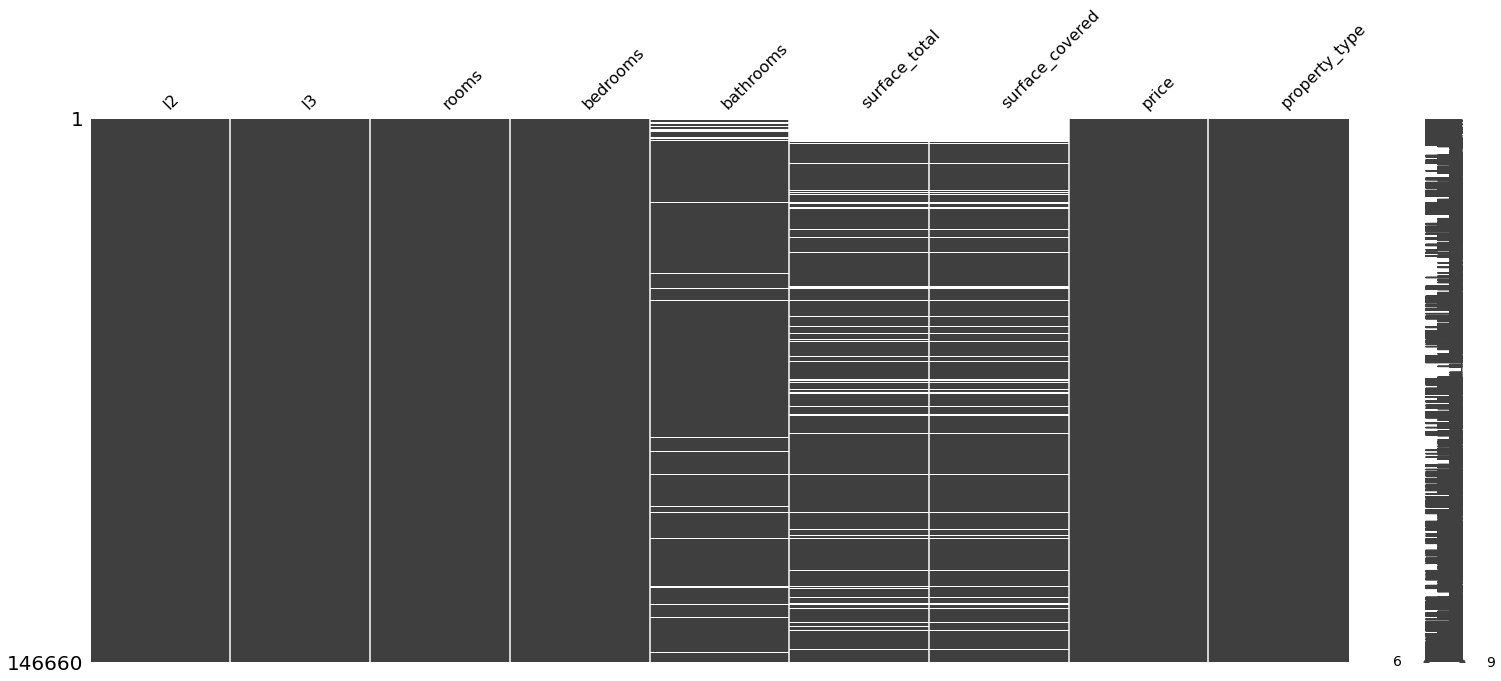

In [146]:
sorted = properati_copy.sort_values('bedrooms')
print("Ordenado por: bedrooms")
msno.matrix(sorted)

Ordenado por: surface_total


<AxesSubplot:>

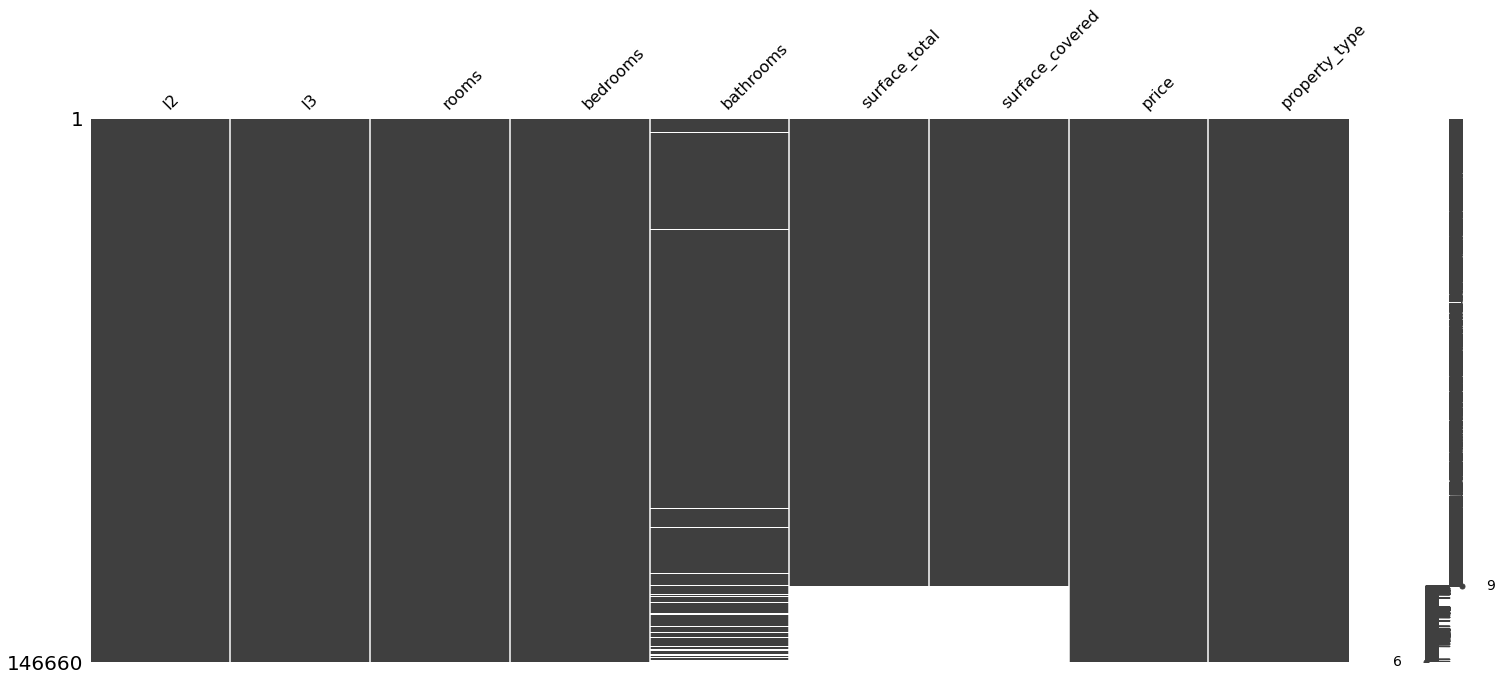

In [147]:
sorted = properati_copy.sort_values('surface_total')
print("Ordenado por: surface_total")
msno.matrix(sorted)

Teniendo en cuenta que donde faltan baños también faltan superficies, entonces eliminaremos los nulos de los baños:
Así pasaremos de 20527 faltantes en superficie a 16622 eliminando 5957 valores faltantes de baños

In [148]:
#Se observa que es el 4% de las publicaciones
properati_copy.isnull().sum()/len(properati_copy)

l2                 0.000000
l3                 0.000000
rooms              0.000000
bedrooms           0.000000
bathrooms          0.040618
surface_total      0.139963
surface_covered    0.136452
price              0.000000
property_type      0.000000
dtype: float64

In [149]:
properati_copy.dropna(how='any',subset=['bathrooms']).isnull().sum()

l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms              0
surface_total      16622
surface_covered    16119
price                  0
property_type          0
dtype: int64

In [150]:
properati_copy=properati_copy.dropna(how='any',subset=['bathrooms'])

Realizeremos la imputación de datos para la superficie total mediante KNN (Extraído del Notebook que nos pasó Juanes)

In [151]:
%%time
from sklearn.impute import KNNImputer
train_knn = properati_copy.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
train_knn['surface_total'] = knn_imputer.fit_transform(train_knn[['surface_total']])

Wall time: 1min 24s


In [152]:
#Crearemos una sencilla función que devuelve los valores máximos y mínimos para la cualquier variable de un data set:
def max_min_func (datacolumn):
    maximo = datacolumn.max()
    minimo = datacolumn.min()
    desviacion = np.std(datacolumn)
    print(f"Los valores max y min para la variable {datacolumn.name} son {maximo} y {minimo} respectivamente, con una sd de {desviacion}")

In [157]:
max_min_func(properati_copy.surface_total)
max_min_func(train_knn.surface_total)
print('\n')
valores_faltantes(train_knn)
#Hay un cambio en la variabilidad de los datos, los disminuye

Los valores max y min para la variable surface_total son 193549.0 y 10.0 respectivamente, con una sd de 2019.837060563795
Los valores max y min para la variable surface_total son 193549.0 y 10.0 respectivamente, con una sd de 1896.781478696243


La columna ['surface_covered'] tiene 16119 valores faltantes


In [158]:
train_knn.isnull().sum()

l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms              0
surface_total          0
surface_covered    16119
price                  0
property_type          0
dtype: int64

In [159]:
%%time
#Vamos a remplazar los valores faltantes de surface_covered por los de surface_total
train_knn2 = train_knn.copy(deep=True)
mascara = train_knn.surface_covered[(train_knn['surface_covered'].isna())]
indexes = mascara.index
#Corremos un for por los indices indicándole que en esos lugares se haga el remplazo
for i in indexes:
    train_knn2.surface_covered[i] = train_knn.surface_total[i]

Wall time: 5.64 s


In [160]:
train_knn2.isnull().any()

l2                 False
l3                 False
rooms              False
bedrooms           False
bathrooms          False
surface_total      False
surface_covered    False
price              False
property_type      False
dtype: bool

La base de datos está completa. Teniendo eso en cuenta y para tener la misma aproximación al modelo del TP1 escogeré aquellas que estén en Capital Federal y que sean Departamento, PH o Casa

In [161]:
mask1 = (train_knn2['property_type'] == 'Departamento') | (train_knn2['property_type'] == 'PH') | (train_knn2['property_type'] == 'Casa')
mask2= train_knn2['l2'] == 'Capital Federal'
properati_new = train_knn2.loc[mask1&mask2]

In [162]:
#Ahora la variable l2 no es útil:
properati_new=properati_new.drop('l2',axis=1)

In [163]:
print("Pasamos de {} a {} observaciones".format(train_knn2.shape[0],properati_new.shape[0]))

Pasamos de 140703 a 89314 observaciones


In [164]:
print("Observemos los cambios de varianza: \n {} \n \n y ahora: \n{}".format(train_knn2.describe(),properati_new.describe()))

Observemos los cambios de varianza: 
                rooms       bedrooms      bathrooms  surface_total  \
count  140703.000000  140703.000000  140703.000000  140703.000000   
mean        3.105819       2.006261       1.599994     213.515615   
std         1.401465       1.131694       0.889324    1896.788219   
min         1.000000       0.000000       1.000000      10.000000   
25%         2.000000       1.000000       1.000000      55.000000   
50%         3.000000       2.000000       1.000000      88.000000   
75%         4.000000       3.000000       2.000000     207.000000   
max        35.000000      15.000000      14.000000  193549.000000   

       surface_covered         price  
count    140703.000000  1.407030e+05  
mean        136.512627  2.392720e+05  
std        1447.745653  2.897480e+05  
min           1.000000  6.000000e+03  
25%          49.000000  1.138005e+05  
50%          75.000000  1.680000e+05  
75%         145.000000  2.650000e+05  
max      193549.000000  3.24

En todos los atributos la varianza disminuyo, excepto en el precio

In [165]:
%%time
matriz_media=train_knn2/train_knn2.mean()
matriz_media_new= properati_new/properati_new.mean()

Wall time: 1min


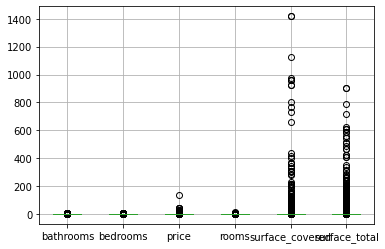

In [166]:
matriz_media.boxplot()
plt.show()

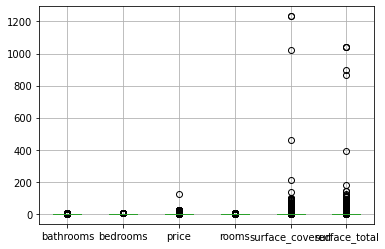

In [167]:
matriz_media_new.boxplot()
plt.show()

Es de esperar que en la capital persistan las propiedades más costosas, arrastrando la media un poco más alto y aumentando la variabilidad de los datos. Es momento de proceder con los outliers

### A.4) Detección y eliminación de outliers:

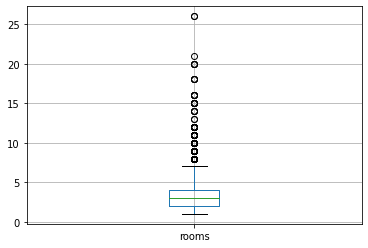

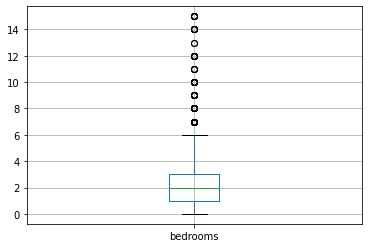

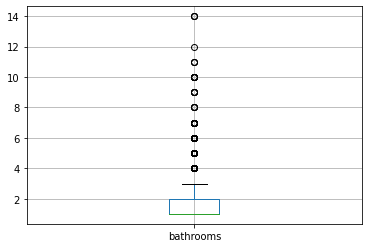

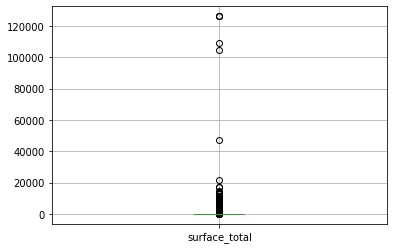

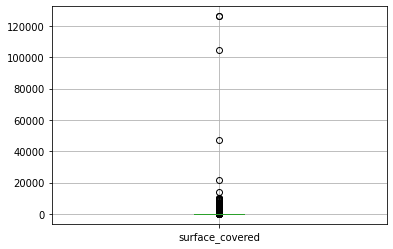

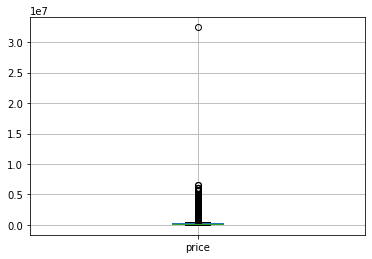

In [168]:
#Primero miremos un resumen de los datos:
variables = properati_new.describe().columns

#Revisamos para cada variable su distribución:
for i in variables:
    plt.figure()
    properati_new.boxplot([i])

In [169]:
for i in variables:
    max_min_func(properati_new[i])

Los valores max y min para la variable rooms son 26.0 y 1.0 respectivamente, con una sd de 1.3142038730161028
Los valores max y min para la variable bedrooms son 15.0 y 0.0 respectivamente, con una sd de 1.0686872586697695
Los valores max y min para la variable bathrooms son 14.0 y 1.0 respectivamente, con una sd de 0.8603042947958165
Los valores max y min para la variable surface_total son 126062.0 y 10.0 respectivamente, con una sd de 943.0091489097408
Los valores max y min para la variable surface_covered son 126062.0 y 1.0 respectivamente, con una sd de 734.9111873793361
Los valores max y min para la variable price son 32434232.0 y 6000.0 respectivamente, con una sd de 324662.83731107035


La superficie y el precio tienen los valores más altos de varianza, por lo que los recortaremos mediante la tecnica de cuartiles

In [170]:
#Las variables con mayor peso de outliers son la superficie y el precio.

#Se eliminaran por rango intercuartílico en un intervalo del 5%
#Definicion de funcion para calcular los rangos intercuartilicos:
#Extraida de : https://medium.com/@prashant.nair2050/hands-on-outlier-detection-and-treatment-in-python-using-1-5-iqr-rule-f9ff1961a414
def outlier_treatment(datacolumn):
    percentile = np.sort(datacolumn)
    Q1,Q2 = np.percentile(percentile , [5,95])
    return Q1,Q2

#Encontramos los rangos:
lowerboun_price,upperboun_price = outlier_treatment(properati_new.price)
lower_surface, upper_surface = outlier_treatment(properati_new.surface_total)

#No obstante como se observo antes, los outliers propblematicos son los de arriba. Por lo que los inferiores no se aplicaran en la mascara
mascara = (properati_new.price < upperboun_price) & (properati_new.surface_total < upper_surface)

#Aplicamos la máscara:
properati_no_out = properati_new[mascara]

print(f'Se borraron: {properati_new.shape[0]-properati_no_out.shape[0]} entradas')

Se borraron: 6771 entradas


In [171]:
max_min_func(properati_no_out.price)
max_min_func(properati_new.price)
#Como vemos la varianza disminuyó bastante
print("\n")
max_min_func(properati_no_out.surface_total)
max_min_func(properati_new.surface_total)

Los valores max y min para la variable price son 697800.0 y 6000.0 respectivamente, con una sd de 117691.6006809048
Los valores max y min para la variable price son 32434232.0 y 6000.0 respectivamente, con una sd de 324662.83731107035


Los valores max y min para la variable surface_total son 239.0 y 10.0 respectivamente, con una sd de 55.49189493822956
Los valores max y min para la variable surface_total son 126062.0 y 10.0 respectivamente, con una sd de 943.0091489097408


<AxesSubplot:>

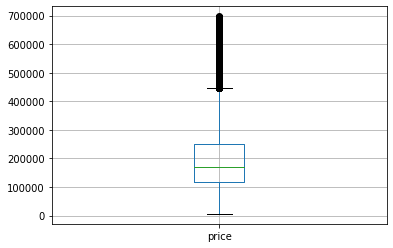

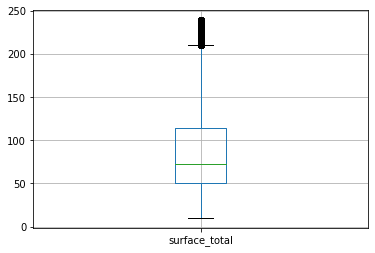

In [172]:
#Revisamos como quedó la base de datos
plt.figure()
properati_no_out.boxplot(['price'])
#Mejoró bastante la distribución del precio
plt.figure()
properati_no_out.boxplot(['surface_total'])
#Sin embargo la superficie total no

In [173]:
properati_no_out

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH
...,...,...,...,...,...,...,...,...
146552,Palermo,4.0,2.0,3.0,159.0,98.0,539000.0,Departamento
146553,Palermo,4.0,3.0,2.0,106.0,100.0,620000.0,Departamento
146554,Palermo,4.0,3.0,3.0,175.0,111.0,570000.0,PH
146555,Palermo,3.0,2.0,2.0,144.0,134.0,480000.0,PH


In [174]:
properati_fin=properati_no_out.copy(deep=True)

In [175]:
properati_fin.isnull().any()

l3                 False
rooms              False
bedrooms           False
bathrooms          False
surface_total      False
surface_covered    False
price              False
property_type      False
dtype: bool

In [176]:
properati_fin.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,82543.000000,82543.000000,82543.000000,82543.000000,82543.000000,82543.000000
mean,2.810608,1.847292,1.439698,90.837104,81.925264,201941.162218
std,1.124090,0.954008,0.701349,55.492231,53.171822,117692.313598
min,1.000000,0.000000,1.000000,10.000000,1.000000,6000.000000
25%,2.000000,1.000000,1.000000,50.000000,45.000000,119340.000000
50%,3.000000,2.000000,1.000000,72.000000,63.000000,168500.000000
75%,4.000000,2.000000,2.000000,114.000000,98.000000,250000.000000
max,21.000000,15.000000,14.000000,239.000000,1050.000000,697800.000000


In [177]:
print(properati_fin.shape)
print("\n")
print(properati_new.shape)

(82543, 8)


(89314, 8)


En comparación con el TP1 (81019) tenemos algo más de mil observaciones extra (82543)

### A.5) Encoders para las variables categóricas:

In [164]:
#Se hará un ecoding basándose en: https://pbpython.com/categorical-encoding.html
#Primero pasar todas la variables a categoricas:
properati_fin2 = properati_fin.copy(deep=True)
categoricas = properati_fin2.select_dtypes(include=['object']).columns
properati_fin2[categoricas] = properati_fin2[categoricas].astype('category')
properati_fin2.dtypes

l3                 category
rooms               float64
bedrooms            float64
bathrooms           float64
surface_total       float64
surface_covered     float64
price               float64
property_type      category
dtype: object

In [165]:
#Verificar la cantidad de categorias por variable
def contador_categorias(data):
    for i in data.select_dtypes(include=['category']).columns:
        print(i)
        print(data[i].unique())
        print('\n')
contador_categorias(properati_fin2)

l3
['San Cristobal', 'Boedo', 'Palermo', 'Villa Crespo', 'Parque Patricios', ..., 'Villa Real', 'Versalles', 'Villa Riachuelo', 'Catalinas', 'Villa Soldati']
Length: 57
Categories (57, object): ['San Cristobal', 'Boedo', 'Palermo', 'Villa Crespo', ..., 'Versalles', 'Villa Riachuelo', 'Catalinas', 'Villa Soldati']


property_type
['Departamento', 'PH', 'Casa']
Categories (3, object): ['Departamento', 'PH', 'Casa']




En este caso se realizará un ecoding a traves de `get_dummies` con ello transformaremos las diferntes categorias de `l3` y `property_type` en columnas. En total se añadirán 59 columnas, correspondientes a 57 de `l3` y 3 de `property_type`, para quedar con un total de 59 columnas

In [166]:
data_dummies = pd.get_dummies (properati_fin2, columns = ['l3','property_type'])

In [167]:
properati_pre_ML=data_dummies

In [168]:
properati_pre_ML.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,l3_Abasto,l3_Agronomía,l3_Almagro,l3_Balvanera,...,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque,property_type_Casa,property_type_Departamento,property_type_PH
0,7.0,7.0,2.0,140.0,140.0,153000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### A.6) Escalamiento de la base de datos:

Primero es necesario separar las variables escalables de las dummies:

In [171]:
properati_num = properati_pre_ML.filter(['rooms','bedrooms','bathrooms','surface_total','surface_covered'], axis=1)

In [172]:
properati_dummies = properati_pre_ML.drop(columns=['rooms','bedrooms','bathrooms','surface_total','surface_covered','price'])

Utilizaremos el escalamiento estandar:

z = (x - u) / s

In [176]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(properati_num)
data_scaled = pd.DataFrame(data_scaled,columns=properati_num.columns)

In [177]:
data_scaled.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered
count,8.254300e+04,8.254300e+04,8.254300e+04,8.254300e+04,8.254300e+04
mean,-1.721631e-18,-9.606698e-17,-6.955387e-17,-1.807712e-17,4.453858e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-1.610742e+00,-1.936359e+00,-6.269359e-01,-1.456737e+00,-1.521967e+00
25%,-7.211281e-01,-8.881440e-01,-6.269359e-01,-7.359112e-01,-6.944560e-01
50%,1.684860e-01,1.600711e-01,-6.269359e-01,-3.394569e-01,-3.559287e-01
75%,1.058100e+00,1.600711e-01,7.988968e-01,4.174104e-01,3.023186e-01
max,1.618154e+01,1.378687e+01,1.790889e+01,2.669992e+00,1.820665e+01


Ahora es necesario volver a concatenar los dataset:

In [178]:
properati_dummies.reset_index(inplace=True, drop=True)
data_scaled.reset_index(inplace=True, drop=True)
properati_pre_ML.price.reset_index(inplace=True, drop=True)
properati_ML = pd.concat([properati_pre_ML.price,data_scaled,properati_dummies], axis=1)

In [180]:
#Damos un vistazo a lo que se tiene:
properati_ML

,price,rooms,bedrooms,bathrooms,surface_total,surface_covered,l3_Abasto,l3_Agronomía,l3_Almagro,l3_Balvanera,...,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque,property_type_Casa,property_type_Departamento,property_type_PH
0,153000.0,3.726942,5.401147,0.798897,0.885947,1.092215,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,159000.0,-0.721128,-0.888144,0.798897,-0.375498,-0.449964,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,125000.0,-0.721128,-0.888144,-0.626936,-0.826014,-0.694456,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,295000.0,-0.721128,-0.888144,-0.626936,-0.105188,-0.600421,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,150000.0,-0.721128,-0.888144,-0.626936,-0.627787,-0.487578,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82538,539000.0,1.058100,0.160071,2.224729,1.228340,0.302319,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
82539,620000.0,1.058100,1.208286,0.798897,0.273245,0.339933,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
82540,570000.0,1.058100,1.208286,2.224729,1.516670,0.546811,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
82541,480000.0,0.168486,0.160071,0.798897,0.958030,0.979373,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [181]:
#%%time
##Creamos una base de datos con la información reescalada:
#properati_ML.to_csv('properati2.csv',index=False)

Wall time: 1.16 s


In [49]:
properati_ML

,price,rooms,bedrooms,bathrooms,surface_total,surface_covered,l3_Abasto,l3_Agronomía,l3_Almagro,l3_Balvanera,...,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque,property_type_Casa,property_type_Departamento,property_type_PH
0,153000.0,3.726942,5.401147,0.798897,0.885947,1.092215,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,159000.0,-0.721128,-0.888144,0.798897,-0.375498,-0.449964,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,125000.0,-0.721128,-0.888144,-0.626936,-0.826014,-0.694456,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,295000.0,-0.721128,-0.888144,-0.626936,-0.105188,-0.600421,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,150000.0,-0.721128,-0.888144,-0.626936,-0.627787,-0.487578,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82538,539000.0,1.058100,0.160071,2.224729,1.228340,0.302319,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
82539,620000.0,1.058100,1.208286,0.798897,0.273245,0.339933,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
82540,570000.0,1.058100,1.208286,2.224729,1.516670,0.546811,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
82541,480000.0,0.168486,0.160071,0.798897,0.958030,0.979373,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


___

___

# PARTE II

___

___

### A.7) Re-entrenamiento de modelo lineal:

La métrica para evaluar será el RMSE, el cuál es la raíz cuadrada del MSE. Dónde se elevan al cuadrado las diferencias para tener más peso en los outliers
$$
RMSE = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(y_{i} - x_{i})^{2}}
$$

Recordemos que en el TP1 el mejor modelo fué el de vecinos cercanos. No obstante como tenemos mayor cantidad de datos y atributos, es muy seguro que esto pueda cambiar.

In [1]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import timeit

properati_ML = pd.read_csv('properati2.csv')
properati_ML.fillna(0,inplace=True)

Wall time: 2.49 s


In [2]:
#Importamos las métricas y funciones necesarias:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score, make_scorer, mean_absolute_error as mae

In [3]:
X = properati_ML.drop('price',axis=1)
y = properati_ML['price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1111)

Raíz del error cuadrático medio en Train: 66722.13666180121
Raíz del error cuadrático medio en Test: 67224.58955420504


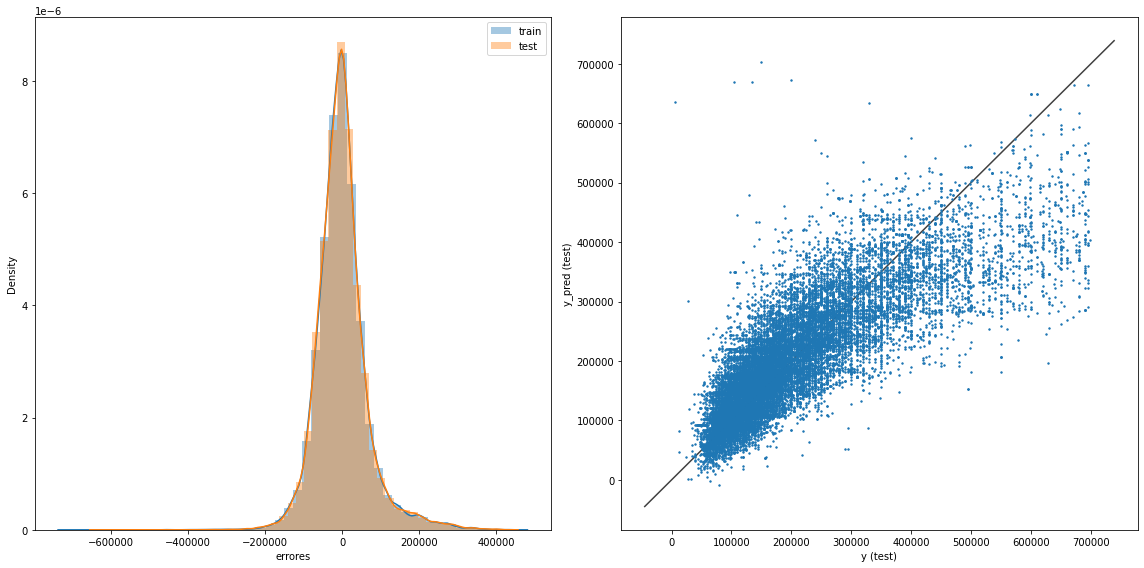

In [4]:
warnings.filterwarnings('ignore')
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)
y_train_pred_lin = linear_model.predict(X_train)
y_test_pred_lin = linear_model.predict(X_test)
rmse_train_lin = np.sqrt(mse(y_train, y_train_pred_lin))
rmse_test_lin = np.sqrt(mse(y_test, y_test_pred_lin))

#Dado que el modelo lineal está en función de cinco variables, su visualización no es posible. Pero podemos ver su comportamiento frente a los errores:

#Definiremos esta función acá para no repetir tanto código:
#Apoyados en el notebook de acámica sacamos este gráfico de los errores
def graficacion_errores(rmse_prueba,rmse_testeo,y_entre_pred,y_prue_pred):
    print(f'Raíz del error cuadrático medio en Train: {rmse_prueba}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_testeo}')
    
    plt.figure(figsize = (16,8))
    
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_entre_pred, bins = 50, label = 'train')
    sns.distplot(y_test - y_prue_pred, bins = 50, label = 'test')
    plt.xlabel('errores')
    plt.legend()
    
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_prue_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()
graficacion_errores(rmse_train_lin,rmse_test_lin,y_train_pred_lin,y_test_pred_lin)

In [5]:
%%time
#Modelo lineal mediante validación cruzada
linear_model = LinearRegression()
#Evaluaremos el MAE
score = make_scorer(mae)
#Ajustamos el modelo a la validación cruzada del tipo LOOCV 'Leave-one-out-cross-validation'
cross_lineal = cross_val_score(linear_model,X=X,y=y,cv=20,scoring=score)

Wall time: 5.83 s


In [6]:
linear_model.fit(X_train,y_train)
print("El valor promedio de la MAE en regresión lineal con 20 pliegues es %0.2f (+/- %0.2f). La RMSE mínima es de %0.2f y máxima %0.2f" % ((cross_lineal).mean(), ((cross_lineal).std()*2), (cross_lineal).min(),(cross_lineal).max()))

El valor promedio de la MAE en regresión lineal con 20 pliegues es 47211.23 (+/- 10365.56). La RMSE mínima es de 39378.01 y máxima 63418.62


Como observamos hay una disminución en el MSE al aplicar Validación Cruzada en vez de un train_test estático

El TP1 tenía los siguientes valores:

Raíz del error cuadrático medio en Train: 279497.05

Raíz del error cuadrático medio en Test: 303193.23

Mientras por validación cruzada en regresión lineal de 20 pliegues hay un promedio de 47211.23 +- 10365.56. Una gran mejora

#### CONCLUSIÓN SECCIÓN A

La ingeniería de features permite tener estimaciones más precisas de la variable respuesta. En este caso el haber imputado valores faltantes y escalado los datos, ha hecho reducir la incertidumbre en la predicción del precio en más de $200.000, lo que demuestra que un tratamiento adecuado en los datos es necesario antes de ejecutar cualquier modelo

___

## SECCIÓN B
___

### SECCIÓN - Modelos Avanzados

* Elige dos de los modelos avanzados vistos Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

* Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

* Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

#### Checklist de evaluación:

    * En la optimización de hiperparámetros, debes justificar los parámetros que elegiste para optimizar y el rango de cada uno.

### B.1) `Árboles de decisión`

Se definirán hiperparámetros para ser buscados mediante `RandomizedSearchCV` y validados por CV

Antes de realizar la búsqueda aleatoria, buscaremos manualmente donde sería la profudidad que nos evite overfitear

In [7]:
%%time
from sklearn.tree import DecisionTreeRegressor

deep = list(np.arange(1,51))
lista_rmse_train_clf = []
lista_rmse_test_clf = []

for i in deep:
    clf = DecisionTreeRegressor(max_depth=i, random_state=42)
    clf.fit(X_train,y_train)
    
    y_train_predclf = clf.predict(X_train)
    y_test_predclf = clf.predict(X_test)
    
    rmse_trainclf = np.sqrt(mse(y_train, y_train_predclf))
    rmse_testclf = np.sqrt(mse(y_test, y_test_predclf))
    
    lista_rmse_train_clf.append(rmse_trainclf)
    lista_rmse_test_clf.append(rmse_testclf)

Wall time: 22.6 s


Text(0, 0.5, 'RMSE')

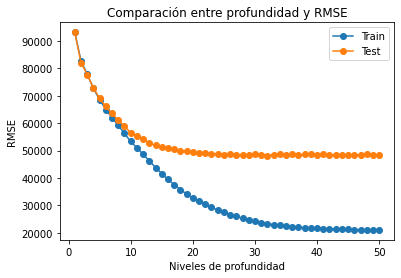

In [8]:
#Realizamos el test visual
plt.plot(deep, lista_rmse_train_clf, 'o-', label='Train')
plt.plot(deep, lista_rmse_test_clf, 'o-', label='Test')
plt.title('Comparación entre profundidad y RMSE')
plt.legend()
plt.xlabel('Niveles de profundidad')
plt.ylabel('RMSE')

Aumentar la profundidad hasta el máximo será la prioridad del algoritmo de búsqueda. Por lo que considero que entre 10 y 15 está el punto de quiebre

In [9]:
#Definir la mátriz de búsqueda de parámetros
parametros = {"max_depth": range(1,15),
             "max_features": range(2,100),
             "min_samples_split": range(2,65),
             "random_state": [42,1111,33]}

In [10]:
%%time
from sklearn.model_selection import RandomizedSearchCV

#Crear el modelo de árboles de decisión
dtr = DecisionTreeRegressor()
# Realizaremos la evaluación aleatoria de parámetros en 100 combinaciones de los parámetros que se pasaron
#Luego de probar con MSE, MAE y R2_score, se considera mejor utilizar R2 cómo métrica de evaluación
score_rfr = make_scorer(r2_score)
dtr_random = RandomizedSearchCV(estimator = dtr, param_distributions = parametros, n_iter = 250, cv = 10, verbose=2, random_state=42, n_jobs = -1,scoring=score_rfr)
# Se corre el modelo, sobre los datos de entrenamiento:
dtr_random.fit(X_train, y_train)
dtr_random.best_params_

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
Wall time: 1min 40s


{'random_state': 1111,
 'min_samples_split': 7,
 'max_features': 65,
 'max_depth': 14}

In [11]:
#Con los mejores estimadores encontrados en la búsqueda aleatoria se procede a calcular los respectivos RMSE
#Guardamos el modelo
dtr_best_estimator=dtr_random.best_estimator_

#Lo ajustamos
y_train_pred_dtr = dtr_best_estimator.predict(X_train)
y_test_pred_dtr = dtr_best_estimator.predict(X_test)

rmse_train_dtr = np.sqrt(mse(y_train, y_train_pred_dtr))
rmse_test_dtr = np.sqrt(mse(y_test, y_test_pred_dtr))

Raíz del error cuadrático medio en Train: 44523.52643185914
Raíz del error cuadrático medio en Test: 51958.41096256781


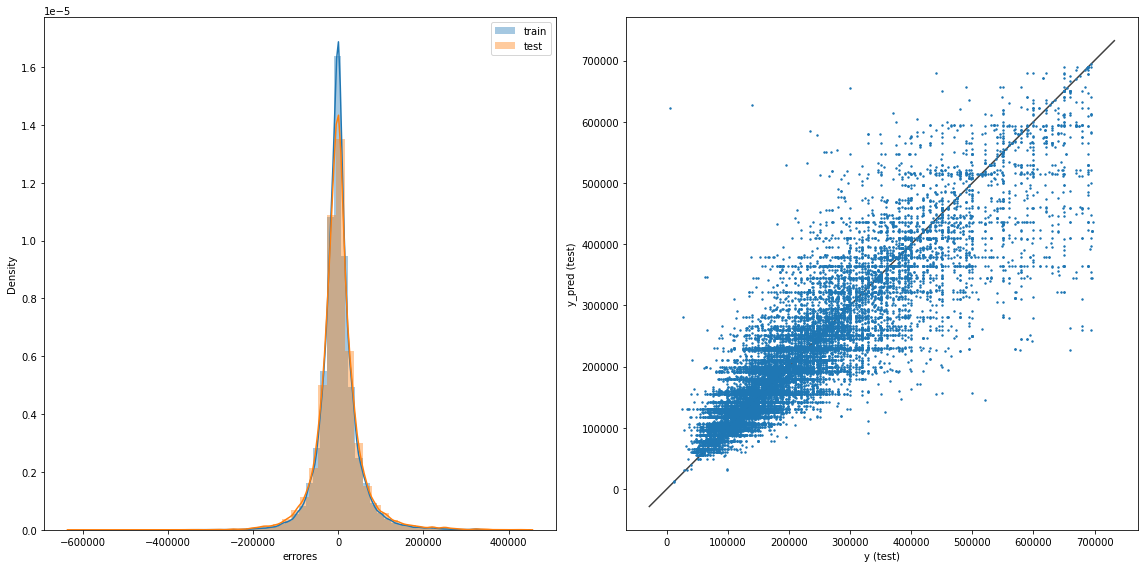

In [12]:
warnings.filterwarnings('ignore')
graficacion_errores(rmse_train_dtr,rmse_test_dtr,y_train_pred_dtr,y_test_pred_dtr)

In [13]:
print("Los mejores parámetros son {} \n con un R2 promedio de {} (+/-{})".
      format(dtr_random.best_params_,
             dtr_random.cv_results_['mean_test_score'][dtr_random.best_index_],
             dtr_random.cv_results_['std_test_score'][dtr_random.best_index_]*2))

Los mejores parámetros son {'random_state': 1111, 'min_samples_split': 7, 'max_features': 65, 'max_depth': 14} 
 con un R2 promedio de 0.8079724103104811 (+/-0.011721247403812937)


Al escoger el árbol con los parámetros mencionados:
 
Se obtiene una RMSE que supera (baja) concreces los demás modelos. Es de reconocer un poco de overfitting entre el train y test. Para ello se intentó evitar el overfiteo reduciendo la profunidad del árbol. No obstante el RMSE cotinua siendo alto, esperaría unos cuantos miles de pesos de diferencia en las predicciones, no cientos de miles.

Ahora analicemos los modelos de ensamble:

### B.2) `RANDOM FOREST`

In [14]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.get_params()
#Se usará la siguiente grilla de parámetros:
parametros_rfr = {"max_depth": range(1,15),
              "n_estimators": [10,30,50,70,100],
             "min_samples_split": range(2,65),
             "random_state": [42,1111,33]}

In [15]:
%%time
#El scoring será el mismo R2
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = parametros_rfr, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1,scoring=score_rfr)
# Se corre el modelo, sobre los datos de entrenamiento:
rfr_random.fit(X_train, y_train)
rfr_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Wall time: 31min 10s


{'random_state': 42,
 'n_estimators': 70,
 'min_samples_split': 3,
 'max_depth': 14}

In [16]:
rfr_best_estimator = rfr_random.best_estimator_

y_train_pred_rfr = rfr_best_estimator.predict(X_train)
y_test_pred_rfr = rfr_best_estimator.predict(X_test)

rmse_train_rfr = np.sqrt(mse(y_train, y_train_pred_rfr))
rmse_test_rfr = np.sqrt(mse(y_test, y_test_pred_rfr))

Raíz del error cuadrático medio en Train: 41621.752254374805
Raíz del error cuadrático medio en Test: 48357.89237872717


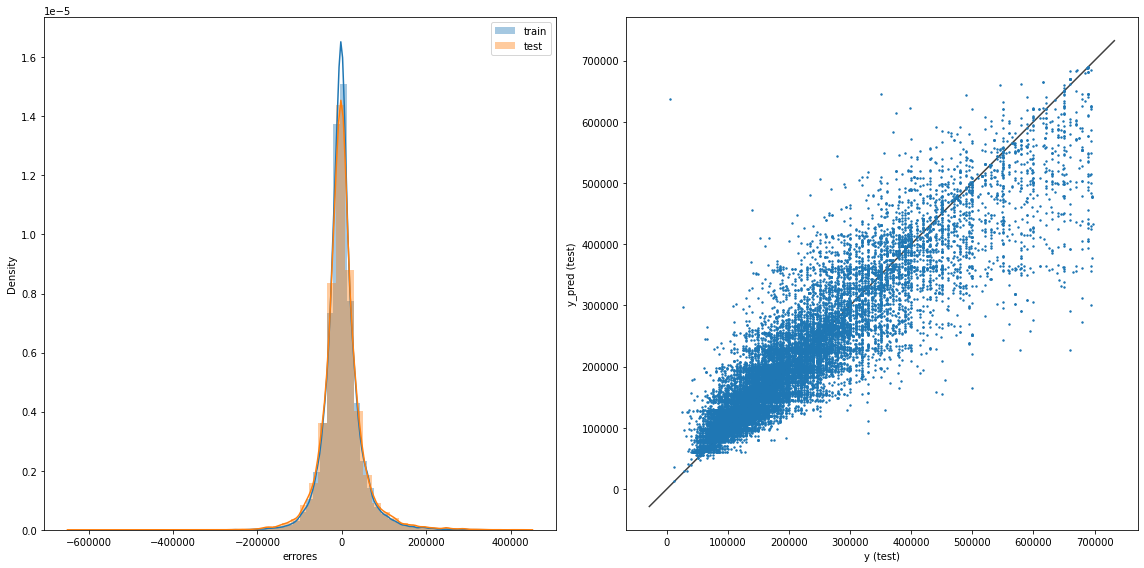

In [17]:
warnings.filterwarnings('ignore')
graficacion_errores(rmse_train_rfr,rmse_test_rfr,y_train_pred_rfr,y_test_pred_rfr)

In [18]:
print("Los mejores parámetros son {} \n con un R2 promedio de {} (+/-{})".
      format(rfr_random.best_params_,
             rfr_random.cv_results_['mean_test_score'][rfr_random.best_index_],
             rfr_random.cv_results_['std_test_score'][rfr_random.best_index_]*2))

Los mejores parámetros son {'random_state': 42, 'n_estimators': 70, 'min_samples_split': 3, 'max_depth': 14} 
 con un R2 promedio de 0.8360079587924082 (+/-0.011489252473166355)


El modelo de Random Forest predice un poco mejor que los árboles de decisión por sí solos. En ese caso con los parámetros descritos anteriormente. Sin embargo realizar 100 interacciones con 10 pliegues de CV se llevó casi una hora. Por lo que esta forma no es muy eficiente. Imagínese sí se hiciera un recorrido por todos los posibles escenario con GridSearchCV. 

Miraremos otros dos modelos de ensamble:

### B.3) XGBoost - GbTree

In [19]:
%%time
#Teniendo en cuenta que 
from xgboost import XGBRegressor
xgbregressor = XGBRegressor(booster='gbtree')
xgbregressor.get_params()
#Dado que serán arboles de decisión por gradiente de descenso intentaremos con estos parámetros
parametros_gbtree = {"max_depth": range(1,20),
                     "n_estimators": [10,30,50,70,100],
                     "random_state": [42,1111,33]}

Wall time: 237 ms


In [20]:
%%time
#El scoring será el mismo R2
score_gbtree = make_scorer(r2_score)
gbtree_random = RandomizedSearchCV(estimator = xgbregressor, param_distributions = parametros_gbtree, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,scoring=score_gbtree)
# Se corre el modelo, sobre los datos de entrenamiento:
gbtree_random.fit(X_train, y_train)
gbtree_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 17min 9s


{'random_state': 33, 'n_estimators': 100, 'max_depth': 12}

In [21]:
gbtree_best_estimator = gbtree_random.best_estimator_
y_train_pred_gbtree = gbtree_best_estimator.predict(X_train)
y_test_pred_gbtree = gbtree_best_estimator.predict(X_test)

rmse_train_gbtree = np.sqrt(mse(y_train, y_train_pred_gbtree))
rmse_test_gbtree = np.sqrt(mse(y_test, y_test_pred_gbtree))

Raíz del error cuadrático medio en Train: 27351.394060921622
Raíz del error cuadrático medio en Test: 41634.80293350754


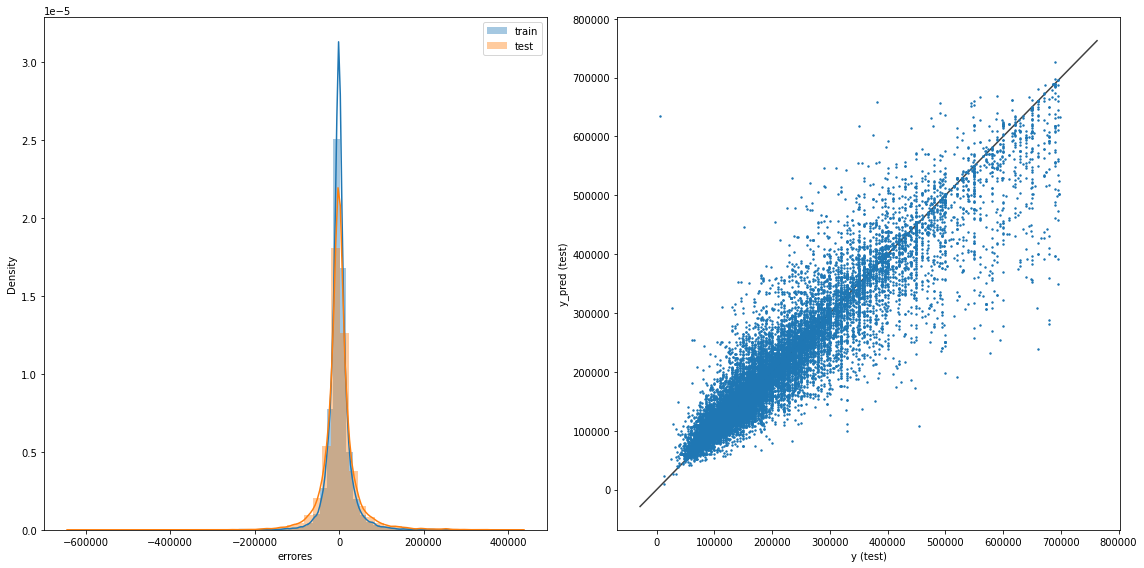

In [22]:
warnings.filterwarnings('ignore')
graficacion_errores(rmse_train_gbtree,rmse_test_gbtree,y_train_pred_gbtree,y_test_pred_gbtree)

In [23]:
print("Los mejores parámetros son {} \n con un R2 promedio de {} (+/-{})".
      format(gbtree_random.best_params_,
             gbtree_random.cv_results_['mean_test_score'][gbtree_random.best_index_],
             gbtree_random.cv_results_['std_test_score'][gbtree_random.best_index_]*2))

Los mejores parámetros son {'random_state': 33, 'n_estimators': 100, 'max_depth': 12} 
 con un R2 promedio de 0.8735335561619969 (+/-0.006226297989561716)


### B.4) XGBoost - GbLinear

In [24]:
%%time
# Fitting XGBoost to the Training set
from xgboost import XGBRegressor
xgblinear = XGBRegressor(booster='gblinear')
#Dado que serán arboles de decisión por gradiente de descenso intentaremos con estos parámetros
parametros_gblinear = {"n_estimators": [10,30,50,70,100,200,500,1000],
                     "random_state": [42,1111,33]}

Wall time: 0 ns


In [25]:
%%time
#El scoring será el mismo R2
score_gblinear = make_scorer(r2_score)
gblinear_random = RandomizedSearchCV(estimator = xgblinear, param_distributions = parametros_gblinear, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,scoring=score_gblinear)
# Se corre el modelo, sobre los datos de entrenamiento:
gblinear_random.fit(X_train, y_train)
gblinear_random.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 2min 20s


{'random_state': 1111, 'n_estimators': 200}

In [26]:
gblinear_best_estimator = gblinear_random.best_estimator_
y_train_pred_gblinear = gblinear_best_estimator.predict(X_train)
y_test_pred_gblinear = gblinear_best_estimator.predict(X_test)

rmse_train_gblinear = np.sqrt(mse(y_train, y_train_pred_gbtree))
rmse_test_gblinear = np.sqrt(mse(y_test, y_test_pred_gbtree))

Raíz del error cuadrático medio en Train: 27351.394060921622
Raíz del error cuadrático medio en Test: 41634.80293350754


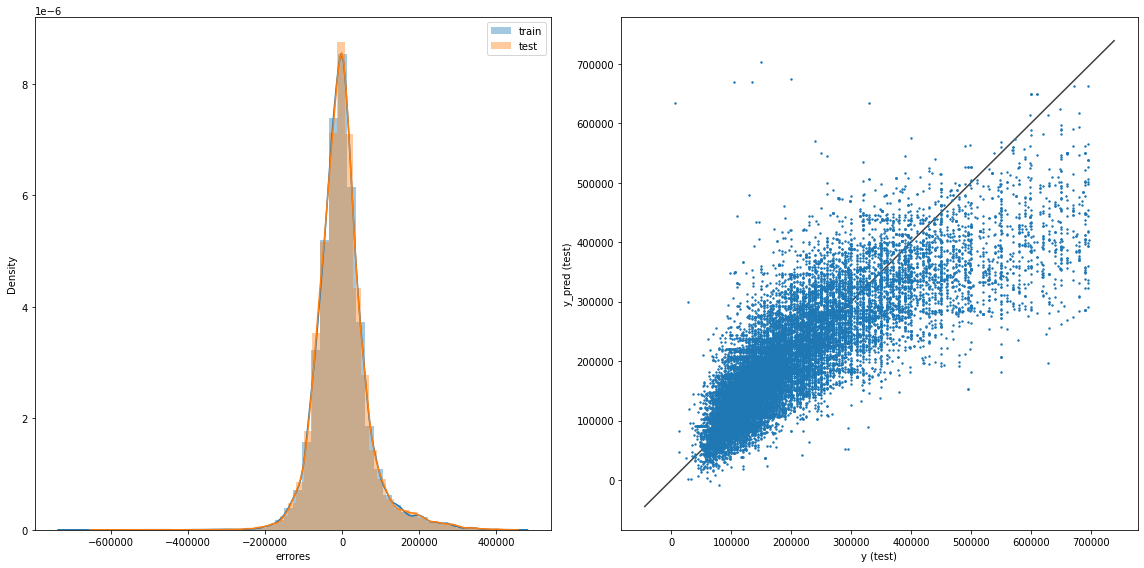

In [27]:
warnings.filterwarnings('ignore')
graficacion_errores(rmse_train_gblinear,rmse_test_gblinear,y_train_pred_gblinear,y_test_pred_gblinear)

In [28]:
print("Los mejores parámetros son {} \n con un R2 promedio de {} (+/-{})".
      format(gblinear_random.best_params_,
             gblinear_random.cv_results_['mean_test_score'][gblinear_random.best_index_],
             gblinear_random.cv_results_['std_test_score'][gblinear_random.best_index_]*2))

Los mejores parámetros son {'random_state': 1111, 'n_estimators': 200} 
 con un R2 promedio de 0.6771180510112966 (+/-0.010544036159382751)


### CONCLUSIÓN SECCIÓN B

Cómo se profundizará en la sección C, los modelos de ensamble permiten una aproximación más ajustada y con menos errores. No obstante entrenar un árbol sin profundidad conducirá a un overfitting de los datos. Escoger los hiperparámetros de la plantilla de búsqueda es vital para reducir el tiempo de computación. Será seguro que siempre escogerá el árbol que tenga más profundidad, y en el caso de un random forest, aquel con mayor cantidad de árbole. Vale la pena mencionar que uno de los hiperparámetros que es el score, no es trivial. Al compartir notebooks con los compañeros veo que en un problema de regresión se está usando una métrica destinada a probabilidad de acierto o no (clasificación).

___

# SECCIÓN C

___

### SECCIÓN C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

* ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

* ¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

#### Checklist de evaluación:

    * Debes estudiar qué variables utiliza el modelo para predecir y responder la pregunta: ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

    * Es muy importante que analices los errores del modelo. ¿Dónde es mayor el error? ¿dónde acierta?

    * Debes ser crítico/a con la metodología utilizada. ¿Qué mejorarías? Ten en cuenta siempre terminar con una discusión sobre lo realizado y conclusiones obtenidas.

### C.1) Métricas de resumen para cada modelo

In [29]:
#Crearemos un for para evaluar cada modelo:
modelos = [linear_model,dtr_best_estimator,rfr_best_estimator,gbtree_best_estimator,gblinear_best_estimator]

mse_train_list = []
rmse_train_list = []
mae_train_list = []
r2_train_list = []

mse_test_list = []
rmse_test_list = []
mae_test_list = []
r2_test_list = []

for model in modelos:
    #Predichos
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test) 
    
    #MSE
    mse_train = mse(y_train,y_train_pred)
    mse_test = mse(y_test,y_test_pred)
    
    #RMSE
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    #MAE    
    mae_train = mae(y_train,y_train_pred) 
    mae_test = mae(y_test,y_test_pred)
    
    #R2
    r2_train = r2_score(y_train,y_train_pred) 
    r2_test = r2_score(y_test,y_test_pred)
    
    #Train_list
    mse_train_list.append(mse_train)
    rmse_train_list.append(rmse_train)
    mae_train_list.append(mae_train)
    r2_train_list.append(r2_train)
    #Test_list
    mse_test_list.append(mse_test) 
    rmse_test_list.append(rmse_test) 
    mae_test_list.append(mae_test) 
    r2_test_list.append(r2_test)
    
resumen = {
    'Modelos': ['Lineal','Árbol de Decisión', 'Random Forest', 'XGBoost_Tree', 'XGBoost_Linear'],
    'MSE para Train': mse_train_list,
    'MSE para Test': mse_test_list,
    'RMSE para Train':rmse_train_list,
    'RMSE para Test':rmse_test_list,
    'MAE para Train':mae_train_list,
    'MAE para Test':mae_test_list,
    'R2 para Train':r2_train_list,
    'R2 para Test':r2_test_list,
            }
resumen_df = pd.DataFrame(resumen)

In [30]:
resumen_df

,Modelos,MSE para Train,MSE para Test,RMSE para Train,RMSE para Test,MAE para Train,MAE para Test,R2 para Train,R2 para Test
0,Lineal,4.451844e+09,4.519145e+09,66722.136662,67224.589554,46664.121651,46738.788434,0.677951,0.675261
1,Árbol de Decisión,1.982344e+09,2.699676e+09,44523.526432,51958.410963,29059.706728,33155.894143,0.856596,0.806005
2,Random Forest,1.732370e+09,2.338486e+09,41621.752254,48357.892379,27845.263457,31415.491272,0.874679,0.831960
3,XGBoost_Tree,7.480988e+08,1.733457e+09,27351.394061,41634.802934,16519.552753,24490.629274,0.945882,0.875436
4,XGBoost_Linear,4.451799e+09,4.518967e+09,66721.803428,67223.266022,46665.915998,46740.480845,0.677954,0.675273


In [31]:
resumen_df['prom_MSE'] = resumen_df[['MSE para Train', 'MSE para Test']].mean(axis=1)
resumen_df['prom_RMSE'] = resumen_df[['RMSE para Train', 'RMSE para Test']].mean(axis=1)
resumen_df['prom_MAE'] = resumen_df[['MAE para Train', 'MAE para Test']].mean(axis=1) 
resumen_df['prom_R2'] = resumen_df[['R2 para Train', 'R2 para Test']].mean(axis=1)

In [32]:
resumen2=resumen_df.drop(['MSE para Train','MSE para Test','RMSE para Train','RMSE para Test','MAE para Train','MAE para Test','R2 para Train','R2 para Test'],axis=1)
resumen2

,Modelos,prom_MSE,prom_RMSE,prom_MAE,prom_R2
0,Lineal,4.485494e+09,66973.363108,46701.455043,0.676606
1,Árbol de Decisión,2.341010e+09,48240.968697,31107.800436,0.831301
2,Random Forest,2.035428e+09,44989.822317,29630.377364,0.853320
3,XGBoost_Tree,1.240778e+09,34493.098497,20505.091014,0.910659
4,XGBoost_Linear,4.485383e+09,66972.534725,46703.198422,0.676614


Teniendo estas métricas y lo discutido en la Sección B. Se observa que los árboles de decisión XGBOOST tiene menores errores en las métricas MSE, RMSE y MAE, y su R2 es el más alto con 0.91. Esto demuestra un modelo más robusto para sus predicciones, pero no tan ligero de atributos. Para saber que tanta importancia tuvieron los atributos en el caso del Random Forest exploremos

### C.2) Errores e Importancia de features

In [98]:
errores=pd.DataFrame({'XGBoost Tree':np.array(((y_test) -(y_test_pred_gbtree))),
               'Árbol de Decisión':np.array(((y_test) -(y_test_pred_dtr))),
               'Reg Lineal':np.array(((y_test) -(y_test_pred_lin))),
               'Random Rorest':np.array(((y_test) -(y_test_pred_rfr))),
               'XGBoost Lin':np.array(((y_test) -(y_test_pred_gblinear)))})
errores   

,XGBoost Tree,Árbol de Decisión,Reg Lineal,Random Rorest,XGBoost Lin
0,-33214.312500,16753.866913,-12800.0,11828.504172,-12833.218750
1,1365.078125,833.333333,-30832.0,144.919725,-30900.203125
2,-1640.875000,-1137.000000,-49840.0,-9952.661268,-50241.453125
3,92582.562500,223067.340164,161976.0,219811.237092,162051.093750
4,-14133.734375,-24264.534102,-1592.0,-25959.477316,-1516.328125
...,...,...,...,...,...
24758,4772.078125,7906.630621,-1123.0,8839.806132,-1165.609375
24759,103913.031250,80239.707317,167592.0,101806.815095,167496.093750
24760,43957.117188,26717.255894,63760.0,26341.462280,64233.750000
24761,9393.343750,-13333.333333,174896.0,2553.503401,174979.437500


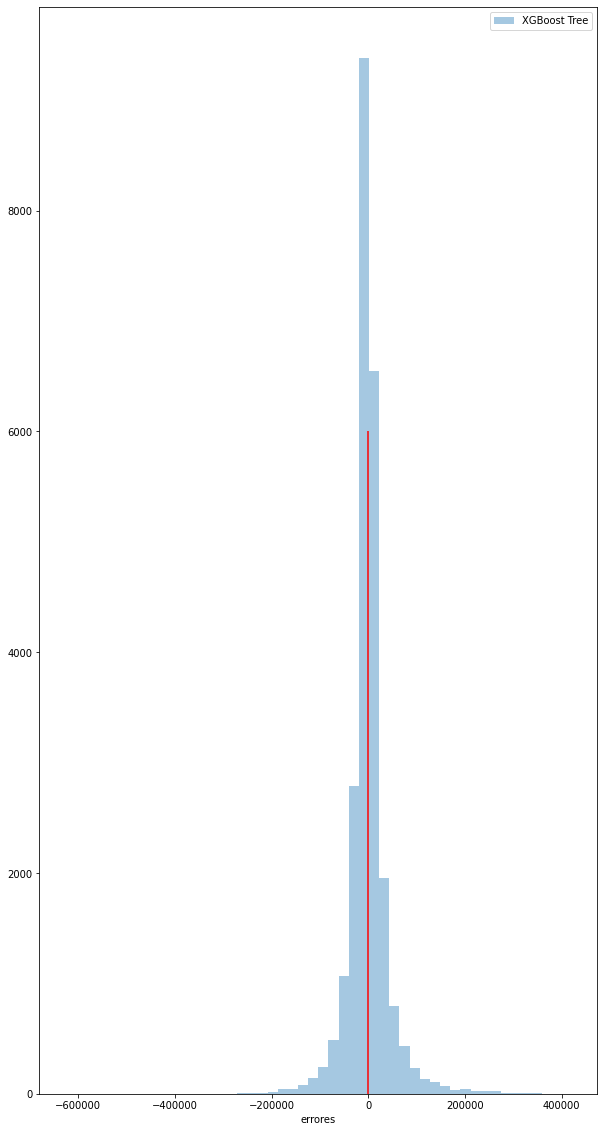

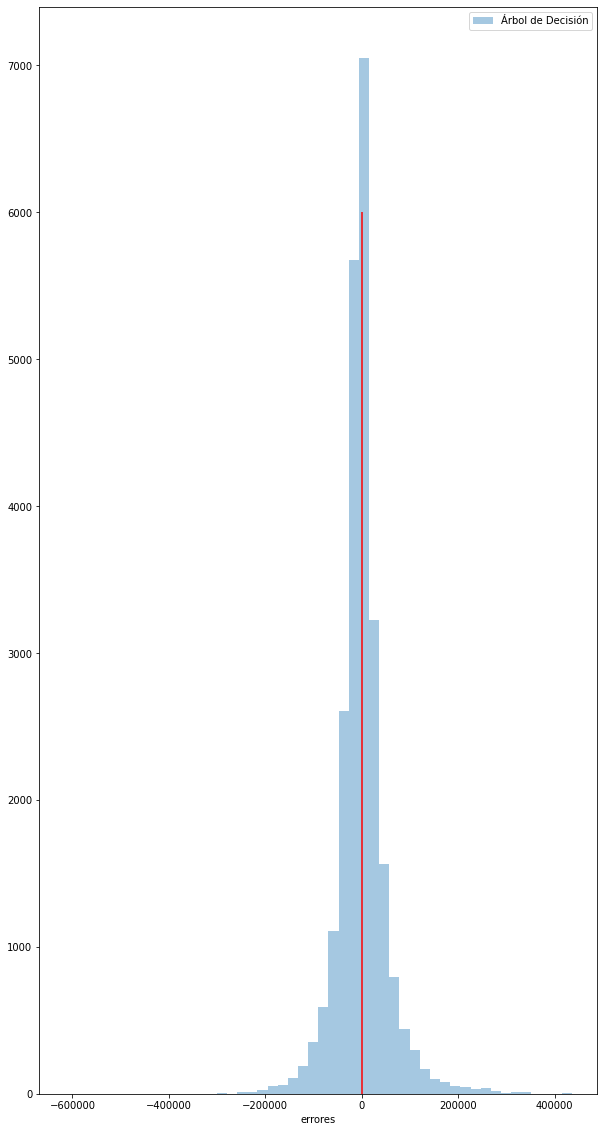

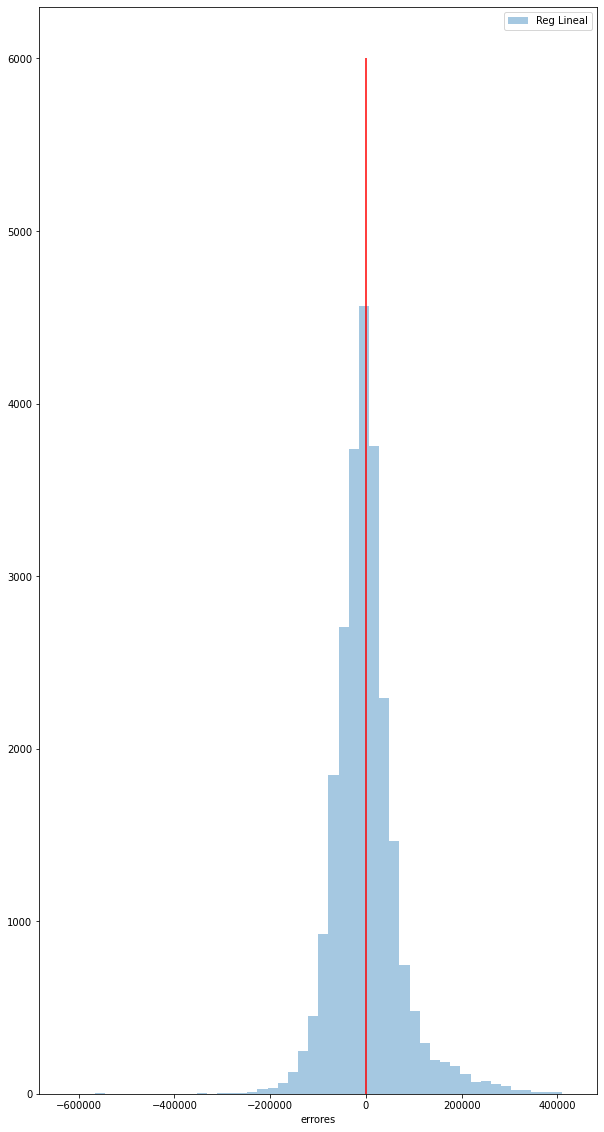

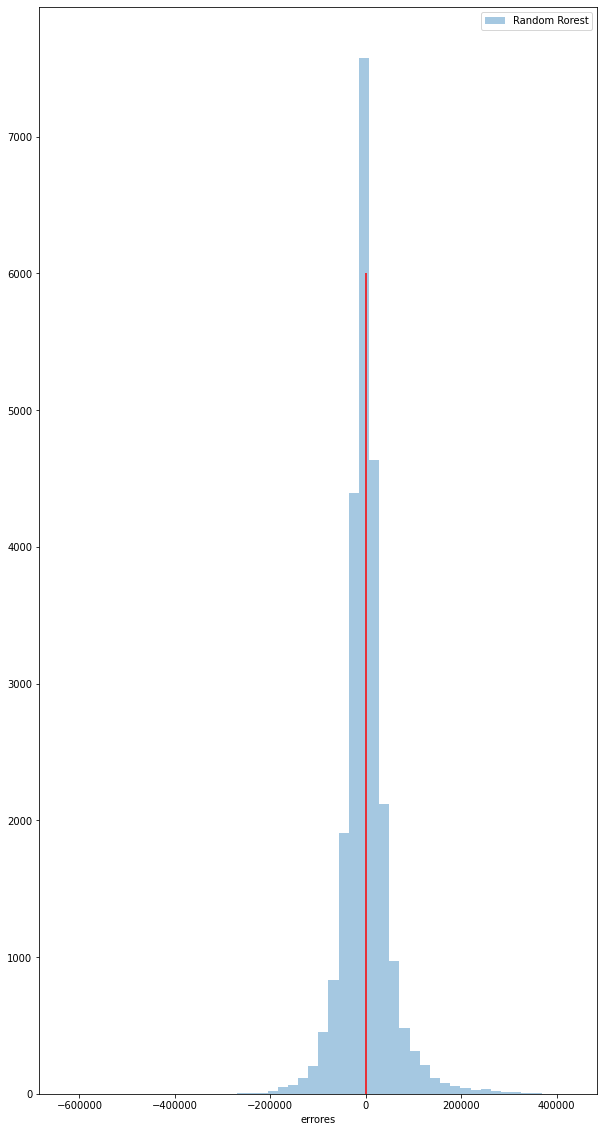

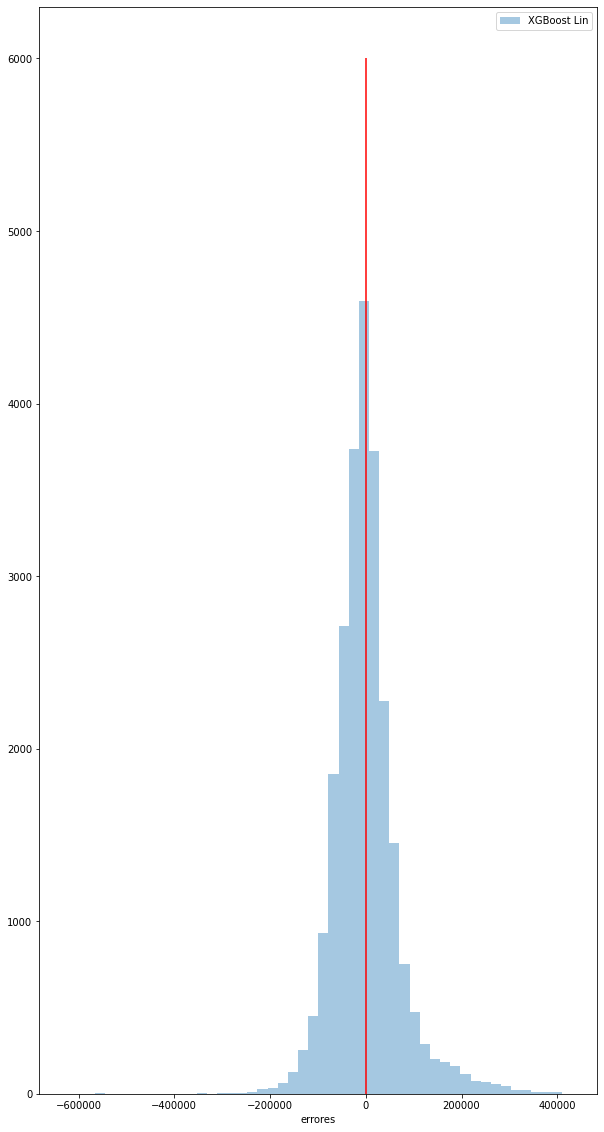

In [101]:
for i in  errores:
    plt.figure(figsize=(10,20))
    sns.distplot(errores[i],label=i,bins=50,kde=False)
    plt.vlines(x=0,ymin=0,ymax=6000,color='red')
    plt.xlabel('errores')
    plt.legend()
    plt.show() 

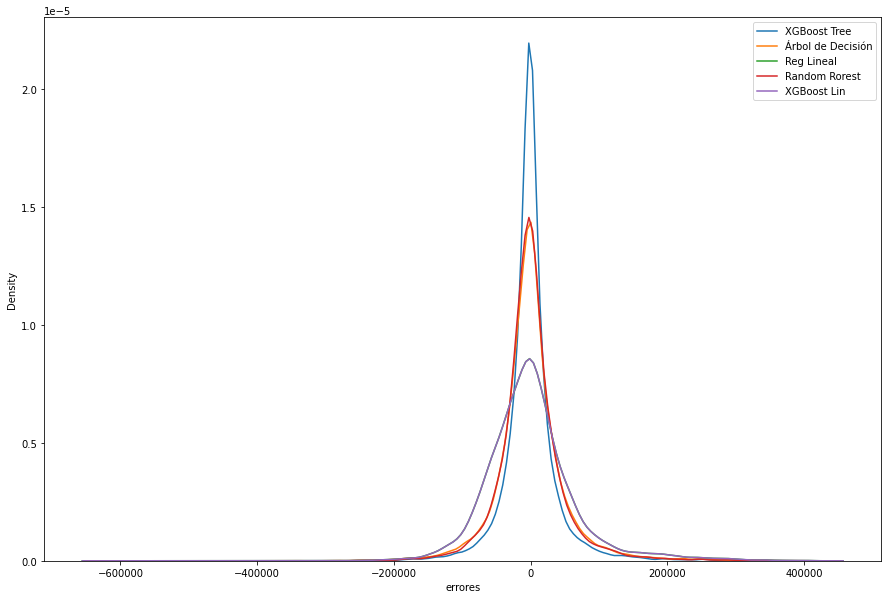

In [65]:
plt.figure(figsize = (15,10))
sns.distplot((y_test) -(y_test_pred_gbtree), label = 'XGBoost Tree',hist=False)
sns.distplot((y_test) -(y_test_pred_dtr), label = 'Árbol de Decisión',hist=False)
sns.distplot((y_test) -(y_test_pred_lin), label = 'Reg Lineal',hist=False)
sns.distplot((y_test) -(y_test_pred_rfr), label = 'Random Rorest',hist=False)
sns.distplot((y_test) -(y_test_pred_gblinear), label = 'XGBoost Lin',hist=False)
plt.xlabel('errores')
plt.legend()
plt.show()

In [100]:
errores2=pd.DataFrame({'XGBoost Tree':np.array(((y_test) -(y_test_pred_gbtree))/y_test),
               'Árbol de Decisión':np.array(((y_test) -(y_test_pred_dtr))/y_test),
               'Reg Lineal':np.array(((y_test) -(y_test_pred_lin))/y_test),
               'Random Rorest':np.array(((y_test) -(y_test_pred_rfr))/y_test),
               'XGBoost Lin':np.array(((y_test) -(y_test_pred_gblinear))/y_test)})
errores2.describe()

,XGBoost Tree,Árbol de Decisión,Reg Lineal,Random Rorest,XGBoost Lin
count,24763.000000,24763.000000,24763.000000,24763.000000,24763.000000
mean,-0.036814,-0.053043,-0.081015,-0.053749,-0.081080
std,0.697001,0.705284,0.754308,0.715576,0.753962
min,-104.676750,-102.663333,-104.870667,-105.152506,-104.816417
25%,-0.100138,-0.152679,-0.249434,-0.151653,-0.249339
50%,-0.005860,-0.007550,-0.024966,-0.011565,-0.025094
75%,0.064191,0.099428,0.152160,0.094431,0.151896
max,0.763494,0.721970,1.113500,0.722413,1.111053


Según la graficación individual de los errores del Test para cada modelo, la de la ditribución teórica, y el error estándar, podemos observar lo siguiente de cada modelo:

* XGBoost Tree: Tiende a subestimar los datos, pero está bastante afilada hacia el 0, lo que representa una buena distribución de valores cercanos a un error de $0. El modelo tiene un promedio de -3,7% en su predicción con sd de 0,69.

* Árbol de decisión: También subestima, sin embargo sigue siendo bueno, estando por encima de la regresión lineal. Error promedio de -5,3% con una sd de 0,7.

* Reg Lineal: Distribución de campana ancha, presenta el error promedio más alto de -8,1% y una varianza de 0,75. Presenta un valor donde sobreestima en 111% el precio

* Random Forest: Similar que el árbol de decisión en promedio error de -5,4% con sd 0.71.

* XGB Linear: Pocos aciertos en el cero con respecto a los otros modelos (excepto lineal), distribución mas ancha con un error promedio de -8,1% y sd de 0,75.

In [137]:
importancia = pd.DataFrame((rfr_best_estimator.feature_importances_), index=X.columns, columns = ['importancia'])
importancia

,importancia
rooms,0.017413
bedrooms,0.011025
bathrooms,0.454418
surface_total,0.146678
surface_covered,0.197953
...,...
l3_Villa Urquiza,0.003218
l3_Villa del Parque,0.000054
property_type_Casa,0.000653
property_type_Departamento,0.019955


In [138]:
importancia.sort_values('importancia',ascending=False)

,importancia
bathrooms,0.454418
surface_covered,0.197953
surface_total,0.146678
l3_Puerto Madero,0.034134
l3_Palermo,0.031553
...,...
l3_Villa Santa Rita,0.000010
l3_Agronomía,0.000008
l3_Villa Real,0.000007
l3_Velez Sarsfield,0.000003


Como se observa los baños y la superficie se llevan casi un 80% de la importancia de los atributos. Ahondar en la importancia de los features realizaremos una pequeña visualización t-SNE (t-distributed stochastic neighbor embedding). La cual permite una visualización en 2 dimensiones para datos multi dimensionales

### C.3) Visualización de varias dimensiones

In [239]:
properati_fin

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,x,y
0,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,6.754947,-2.133265
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,9.700674,-5.876545
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,-0.543515,3.453178
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,7.353641,1.596423
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH,3.206815,-1.344083
...,...,...,...,...,...,...,...,...,...,...
146552,Palermo,4.0,2.0,3.0,159.0,98.0,539000.0,Departamento,-5.765043,-9.757033
146553,Palermo,4.0,3.0,2.0,106.0,100.0,620000.0,Departamento,0.199675,-11.906075
146554,Palermo,4.0,3.0,3.0,175.0,111.0,570000.0,PH,6.039153,4.670937
146555,Palermo,3.0,2.0,2.0,144.0,134.0,480000.0,PH,6.748994,-7.328733


Voy a escoger la cantidad de barrios que permitan capturar al menos el 60% de los datos:

In [248]:
barrios = properati_fin.l3.value_counts().rename_axis('l3').reset_index(name='freq')
barrios['cumsum']=barrios.freq.cumsum()/len(properati_fin)
barrios.head(10)

,l3,freq,cumsum
0,Palermo,11401,0.138122
1,Almagro,7171,0.224998
2,Caballito,6255,0.300777
3,Villa Crespo,6254,0.376543
4,Belgrano,6008,0.449329
5,Recoleta,4929,0.509044
6,Villa Urquiza,3159,0.547315
7,Barrio Norte,2942,0.582957
8,Balvanera,2717,0.615873
9,Flores,2350,0.644343


In [264]:
#Con los 10 primeros ya tenemos el 64% de los datos. Es suficiente
barrios_top10 = barrios.iloc[0:9,0]
barrios_select = (properati_fin.l3.isin(barrios_top10))
properati_top10 = properati_fin.loc[barrios_select,:]

In [267]:
properati_top10.l3.value_counts()

Palermo          11401
Almagro           7171
Caballito         6255
Villa Crespo      6254
Belgrano          6008
Recoleta          4929
Villa Urquiza     3159
Barrio Norte      2942
Balvanera         2717
Name: l3, dtype: int64

Visualizaremos ahora este DataSet reducido para intentar comprender mejor sí hay alguna tendencia entre ellos

In [274]:
%%time
from sklearn.manifold import TSNE
m= TSNE(learning_rate=10,n_jobs=-1,n_iter=500,verbose=2)
non_numeric = ['l3','property_type']
prope_num = properati_top10.drop(non_numeric,axis=1)

tsne_features = m.fit_transform(prope_num)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50836 samples in 0.132s...
[t-SNE] Computed neighbors for 50836 samples in 0.541s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50836
[t-SNE] Computed conditional probabilities for sample 2000 / 50836
[t-SNE] Computed conditional probabilities for sample 3000 / 50836
[t-SNE] Computed conditional probabilities for sample 4000 / 50836
[t-SNE] Computed conditional probabilities for sample 5000 / 50836
[t-SNE] Computed conditional probabilities for sample 6000 / 50836
[t-SNE] Computed conditional probabilities for sample 7000 / 50836
[t-SNE] Computed conditional probabilities for sample 8000 / 50836
[t-SNE] Computed conditional probabilities for sample 9000 / 50836
[t-SNE] Computed conditional probabilities for sample 10000 / 50836
[t-SNE] Computed conditional probabilities for sample 11000 / 50836
[t-SNE] Computed conditional probabilities for sample 12000 / 50836
[t-SNE] Computed conditional probabilities for sam

In [275]:
properati_top10['x'] = tsne_features[:,0]
properati_top10['y'] = tsne_features[:,1]

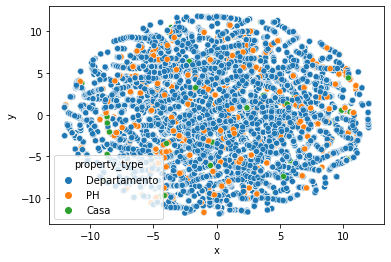

In [278]:
sns.scatterplot(x='x',y='y', hue = 'property_type',data=properati_fin)
plt.show()

Luego de varios intentos de reducir la cantidad de features, es muy dificil ver algún patrón que determine alguna clusterización

### CONCLUSIÓN SECCIÓN C

Acá termina el TP2. Fué un ejercicio interesante el haber desarrollado modelos que, posiblemente, de intentar ser implementados "from scratch" sería una tarea épica.  El tener a disposición funciones tan elaboradas hace que nos concentremos mucho en ejecutar y buscar el mejor score, pero nos quedamos cortos con la teoría que hay detrás, ignorando que un árbol de decisiones elegido "automaticamente" será de una alta varianza, pues tenderá a overfitear el training set.

Me quedo con la idea de imputar todas las coordenadas de acuerdo al nombre del barrio. Es decir, mediante sistemas de información geográfico podría calcular una coordenada ubicada en el centroide de cada barrio, y así imputarlo al dataset. Tener acceso a una "clusterización" con las coordenadas sería un poco más objetivo que encodear las 59 categorías, y reduciría variables pudiendo crear 4 dummies como "Norte" "Este" "Oeste" "Sur".

Espero haber cumplido con el objetivo.

Gracias!!